In [3]:
#env 로드
import os
import topogenesis as tg
import trimesh as tm
import numpy as np
import pyvista as pv
import panel as pn
import pandas as pd 
import copy

import ipywidgets as widgets
from ladybug.sunpath import Sunpath #ladybug sunpath 호출
from IPython.display import display, Image
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler

# csv에서 lattice 배열 만드는 함수 정의
def lattice_from_csv(file_path):
    # 데이터를 읽어옴
    meta_df = pd.read_csv(file_path, nrows=3)
    # shape, unit, minbound 데이터를 배열로 변환
    shape = np.array(meta_df['shape'])       # 시작 좌표 [x_min, y_min, z_min] 예를 들어, [-55000, -7000, 0] x축 -55000, y축 -7000, z축 0의 위치
    unit = np.array(meta_df['unit'])         # 몇개의 셀로 구성되는지 [x_shape, y_shape, z_shape] 예를 들어 [56, 35, 24]이면 x축 56개, y 35개, z 24개의 셀을 가집니다.
    minbound = np.array(meta_df['minbound']) # 각 셀의 크기. 예를 들어, [1000, 1000, 3000] 각 셀의 크기는 x축 1000 단위, y축 1000 단위, z축 3000 단위
    # np.array는 csv에서 불러온 데이터를 배열로 변환하는데 사용 
    # 그리드 데이터를 읽어옴
    lattice_df = pd.read_csv(file_path, skiprows=5) # 앞의 5개 줄을 스킵하고 6개 부터 데이터를 불러오기
    # 데이터의 'value' 열을 배열로 변환한 후 이를 'shape' 배열에 맞게 재구성 
    buffer = np.array(lattice_df['value']).reshape(shape)
    # lattice를 토포제네시스에서 재구성 buffer는 배열에 맞는 value값. 
    l = tg.to_lattice(buffer, minbound=minbound, unit=unit)
    
    return l

# tri_to_pv 함수 정의: 삼각형 메시(tri_mesh)를 PyVista 형식으로 변환합니다.
def tri_to_pv(tri_mesh):
    #  tri_mesh.faces 배열에 각 face의 시작 부분에 3을 추가하여 새로운 배열을 만듭니다.
    # 'constant' 모드로 패딩을 추가하여 각 face의 시작에 3을 삽입합니다.
    faces = np.pad(tri_mesh.faces, ((0, 0), (1, 0)), 'constant', constant_values=3)
    # PyVista의 PolyData 객체를 생성하여, tri_mesh의 정점(vertices)과 패딩된 faces 배열을 사용합니다.
    pv_mesh = pv.PolyData(tri_mesh.vertices, faces)    
    # 변환된 PyVista 메쉬 객체를 반환합니다.
    return pv_mesh

# 1이라는 범위에 대한 이웃패턴 정의 (중심을 포함함)
stencil = tg.create_stencil("von_neumann", 1, 1)
# 중심을 인덱스 비활성화 - [0,0,0]을 0으로 세팅함으로 중심을 패턴 비활성화
stencil.set_index([0,0,0], 0)


In [4]:
#csv 로드
csv_path = os.path.relpath('original_lattice/interior_lattice.csv')
#obj 포인트 csv 로드
context_mesh = tm.load(os.path.relpath('obj\context.obj'))  # 주변환경 obj 메시 불러오기
street_pc = tg.cloud_from_csv("pts\pts_str(11).CSV")        # street point as csv (포인트를 csv로 저장) 
entrance_pc = tg.cloud_from_csv("pts\ent_pts01.CSV")        # entrance point as csv (라이노 포인트를 csv로 저장)
envelope_lattice = tg.lattice_from_csv(csv_path)

avail_lattice = tg.lattice_from_csv(csv_path)                                         # CSV 파일에서 격자 데이터 불러오기
init_avail_lattice = tg.to_lattice(np.copy(avail_lattice), avail_lattice)             # 복사된 데이터를 격자 객체로 변환

In [5]:
# 'excel/program (이노션).xlsx' 파일에서 'Sheet1' 시트를 읽어옴
df = pd.read_excel('excel/program (이노션).xlsx', sheet_name='Sheet1')
program_prefs = df[['sun_acc', 'ent_acc', 'str_acc', 'ung_pre', 'dist_facade','top_pre']].copy()

# 인덱스를 재설정(기존 index를 버리고 새로운 인덱스로) 0부터 숫자 인덱스를 생성
program_prefs.reset_index(drop=True, inplace=True)
fields = {}  # 필드를 저장할 빈 딕셔너리를 생성

for f in program_prefs.columns:  # 각 필드에 대한 파일 경로 설정    
    lattice_path = os.path.relpath('matrixs/' + f + '.csv')      
    try:        
        fields[f] = tg.lattice_from_csv(lattice_path)  # 배열 파일에서 데이터를 불러와서 fields 딕셔너리에 저장
    except:        
        fields[f] = copy.deepcopy(avail_lattice * 0 + 1)# 파일이 없을 경우, 모든 값을 1로 설정한 기본 격자 데이터를 fields 딕셔너리에 저장


top_pre_index = df.columns.get_loc('top_pre') # 'top_pre' 열의 인덱스 찾기 (5번째에 위치)
program_mtx = df.iloc[:, top_pre_index + 1:]  # 'top_pre' 열 이후 모든 열을 포함하는 새로운 데이터프레임 생성 (프로그램 상관관계 matrix 찾기)
program_mtx.columns = range(len(program_mtx.columns)) # 새로운 데이터프레임의 열 이름을 0부터 시작하는 숫자로 변경     (프로그램 번호입력 0~ ) 

space_list = df['space_name'].to_dict() # 'space_name' 열을 딕셔너리로 변환하여 'space_list'에 저장
sizes_complete = df['vox_amount']# 'vox_amount' 열의 값을 가져와 'sizes_complete'에 저장

agent_areas = [] # 'agent_areas' 리스트 초기화

for area in sizes_complete: # 'sizes_complete'의 각 값에 대해 반복 
    agent_areas.append(round(int(area)))    # 각 값을 정수로 변환하고 반올림하여 'agent_areas'에 추가

print(space_list)   # 변환된 딕셔너리를 출력
print(agent_areas)  # 'agent_areas' 리스트를 출력
print(program_prefs)
print(program_mtx)

{0: 'Lobby', 1: 'Branding Space', 2: 'External Contact', 3: 'Interview Room', 4: 'Personal Workspace', 5: 'Work Support Area', 6: 'Personal Locker Room', 7: 'Executive Space', 8: 'VIP Reception', 9: 'Secretary Room', 10: 'Pantry', 11: 'Executive Meeting', 12: 'Executive Offices', 13: 'Focus Rooms', 14: 'Project Rooms', 15: 'Conference Rooms', 16: '4-Person Meeting', 17: '6-Person Meeting', 18: '8-Person Meeting', 19: '12-Person Meeting', 20: '18-Person Meeting', 21: 'Idea Room', 22: 'Mail Room', 23: 'Oasis', 24: 'PT Practice Room', 25: 'Screening Room', 26: 'Studio', 27: 'Video Editing', 28: 'Plotter/Board Room', 29: 'Training Room', 30: 'Ino Kitchen', 31: 'Kitchen', 32: 'Ino Cafe', 33: 'Fitness Facilities', 34: 'Dressing/Shower', 35: 'Counseling Room', 36: 'Personal Rest Room', 37: 'Sleeping Room', 38: 'Nursing Room', 39: 'Work Lounge', 40: 'Town Hall', 41: 'Seminar Room', 42: 'Library', 43: 'Social Space', 44: 'Outdoor Terrace', 45: "Driver's Waiting", 46: 'Server Room', 47: 'Cleanin

In [6]:

#     return occ_lattice, agn_locs

In [7]:
max_agents_per_floor = 6  # 각 층에 배치할 수 있는 최대 에이전트 수
occ_lattice = avail_lattice * 0 - 1# 가용 격자를 모두 -1로 초기화 (모든 셀을 사용 불가능으로 설정)
init_occ_lattice = np.copy(occ_lattice) # 초기 점유 격자의 복사본 생성

agn_locs = [None] * len(program_prefs) # 각 에이전트의 위치를 저장할 리스트 초기화
floor_counts = np.zeros(avail_lattice.shape[2], dtype=int) # 각 층의 에이전트 수를 추적하는 배열 초기화

In [8]:
def calculate_weighted_average(values, weights):
    return sum(v * w for v, w in zip(values, weights)) / sum(weights)

In [9]:
print(program_mtx.shape)
print(program_mtx.head())

(51, 51)
    0    1    2    3    4    5    6    7    8    9   ...   41   42   43   44  \
0  1.0  0.9  1.0  0.7  0.7  0.1  0.1  0.3  0.6  0.6  ...  0.7  0.5  0.6  0.1   
1  0.9  1.0  0.1  1.0  0.3  0.1  0.1  0.1  0.6  0.5  ...  0.1  0.6  0.1  0.1   
2  1.0  0.1  1.0  0.3  1.0  0.1  0.1  0.3  0.5  0.1  ...  0.1  0.1  0.1  0.1   
3  0.7  1.0  0.3  1.0  0.1  1.0  1.0  1.0  0.1  0.1  ...  0.3  0.4  0.6  0.5   
4  0.7  0.3  1.0  0.1  1.0  1.0  1.0  0.5  0.1  0.1  ...  0.4  0.6  0.6  0.2   

    45   46   47   48   49   50  
0  0.1  0.1  0.3  0.3  0.3  0.3  
1  0.1  0.1  0.3  0.3  0.3  0.3  
2  0.1  0.1  0.3  0.3  0.3  0.3  
3  0.1  0.1  0.3  0.3  0.3  0.3  
4  0.1  0.1  0.8  0.3  0.3  0.3  

[5 rows x 51 columns]


In [10]:
# # 예시 데이터 설정
# avail_lattice = np.array([[1, 0], [1, 1]])  # 2x2 격자에서 일부 폭셀만 사용 가능
# fields = {
#     'field_0': np.array([[0.2, 0.3], [0.4, 0.5]]),
#     'field_1': np.array([[0.6, 0.7], [0.8, 0.9]]),
# }
# program_prefs = pd.DataFrame({
#     'field_0': [0.5, 0.3],  # 각 에이전트의 선호도 예시
#     'field_1': [0.5, 0.7]
# })

# agn_num = len(program_prefs) 
# occ_lattice = avail_lattice * 0 
# avail_flat = avail_lattice.flatten()
# avail_index = np.array(np.where(avail_lattice == 1)).T

# agn_locs = [None] * agn_num

# # 평균을 계산하는 부분
# for a_id, a_prefs in program_prefs.iterrows():
#     pref_lattice = avail_lattice * 0.0
#     total_additions = 0
    
#     for f, w in a_prefs.items():
#         pref_lattice += fields[f] * w
#         total_additions += 1
#         print(f"Agent {a_id} - Total Additions: {total_additions}")
#         print(f"Agent {a_id} - Pref Lattice (after adding {f}):\n{pref_lattice}\n")
    
#     pref_lattice /= total_additions  # 더한 횟수로 나누어 평균 계산
#     flat_pref_lattice = pref_lattice.flatten()
    
#     print(f"Agent {a_id} - Final Pref Lattice:\n{pref_lattice}\n")
#     print(f"Agent {a_id} - Flat Pref Lattice:\n{flat_pref_lattice}\n")

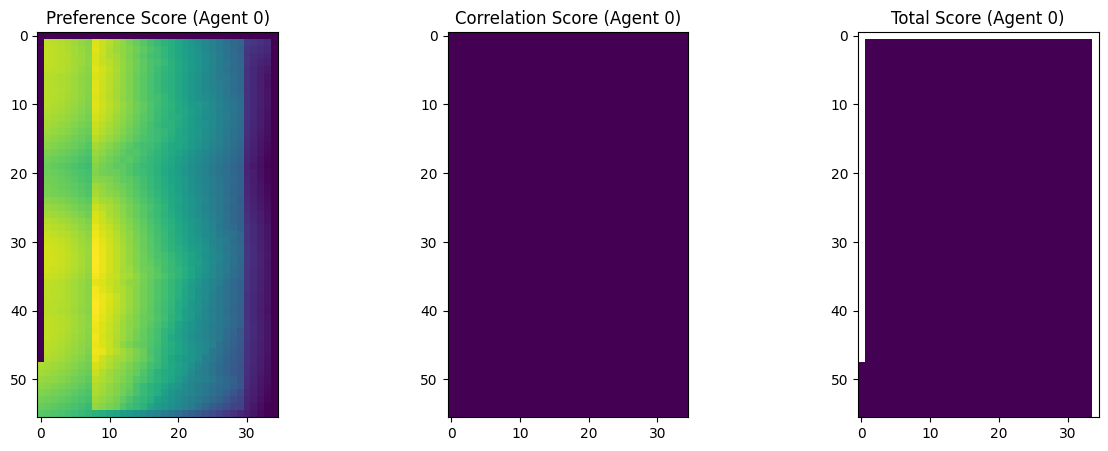

Agent 0:
Best location: (1, 1, 0)
Preference score at best location: 0.6677
Correlation score at best location: 0.0000
Total score at best location: 1.0000




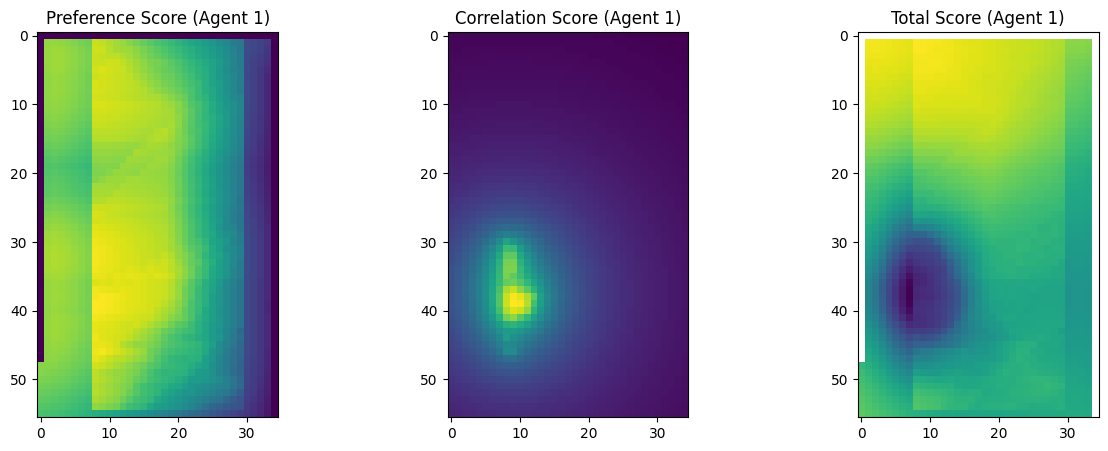

Agent 1:
Best location: (1, 8, 5)
Preference score at best location: 0.7015
Correlation score at best location: 0.0243
Total score at best location: 0.9914




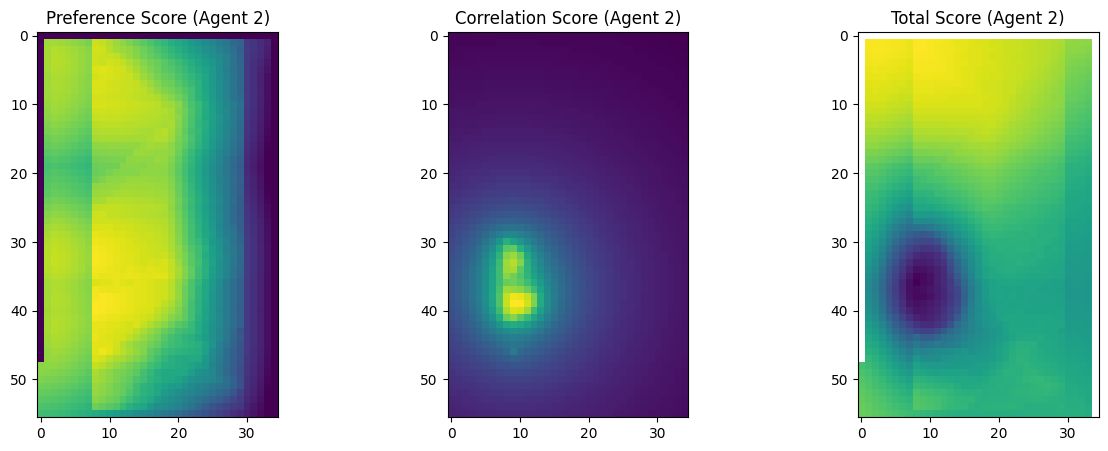

Agent 2:
Best location: (2, 8, 5)
Preference score at best location: 0.7110
Correlation score at best location: 0.0156
Total score at best location: 0.9947




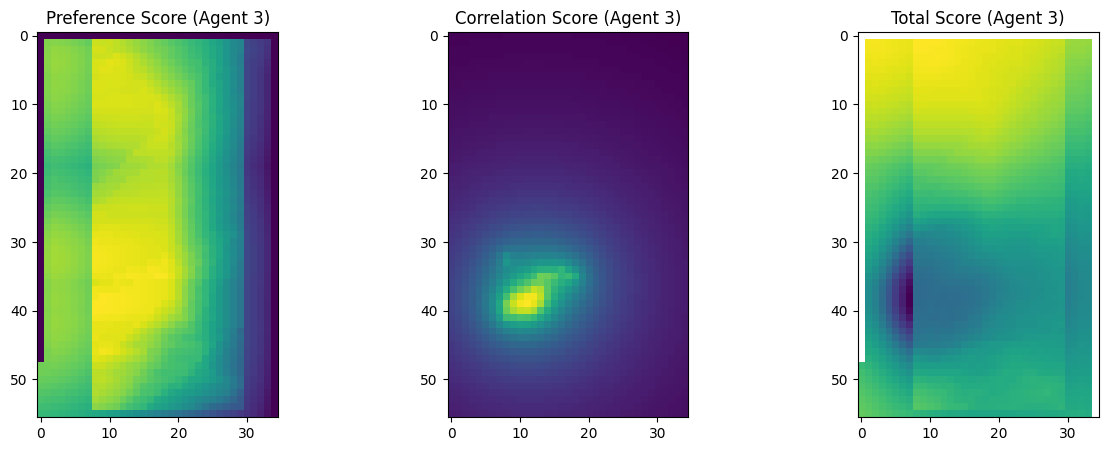

Agent 3:
Best location: (1, 10, 7)
Preference score at best location: 0.6316
Correlation score at best location: 0.0178
Total score at best location: 0.9918




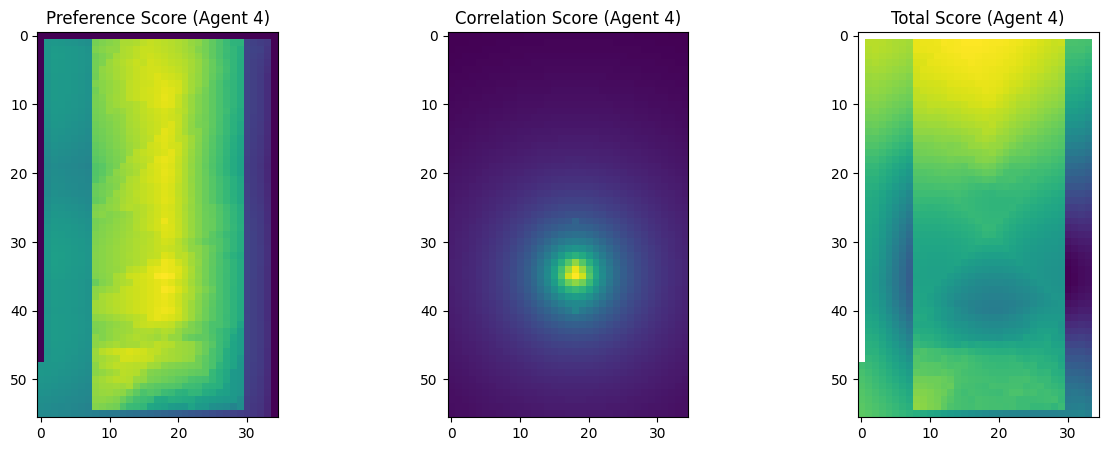

Agent 4:
Best location: (1, 16, 13)
Preference score at best location: 0.6156
Correlation score at best location: 0.0150
Total score at best location: 0.9927




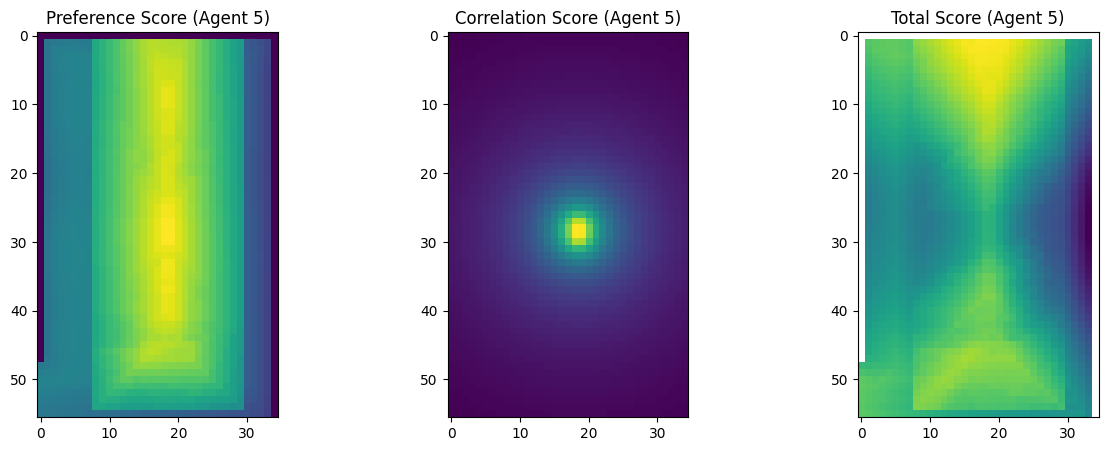

Agent 5:
Best location: (1, 17, 13)
Preference score at best location: 0.6318
Correlation score at best location: 0.0160
Total score at best location: 0.9927




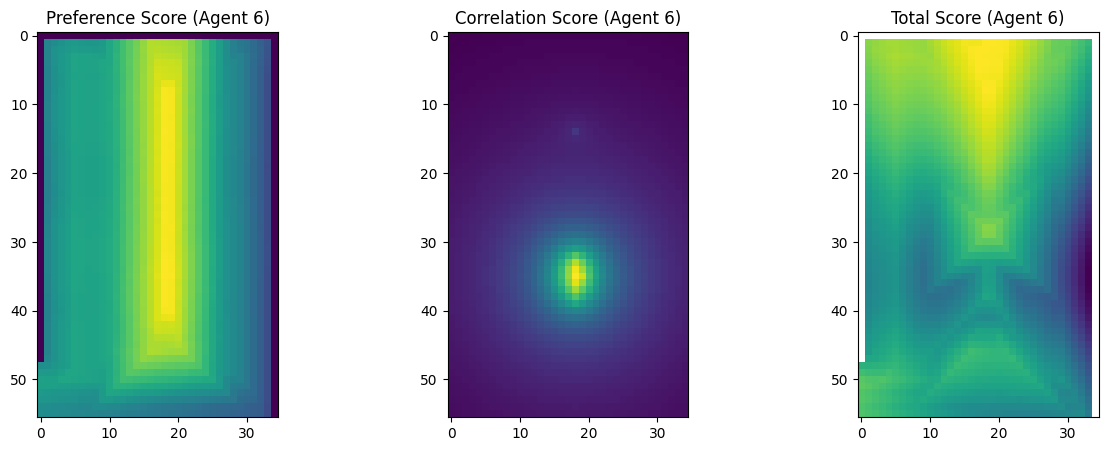

Agent 6:
Best location: (4, 17, 13)
Preference score at best location: 0.6535
Correlation score at best location: 0.0152
Total score at best location: 0.9935




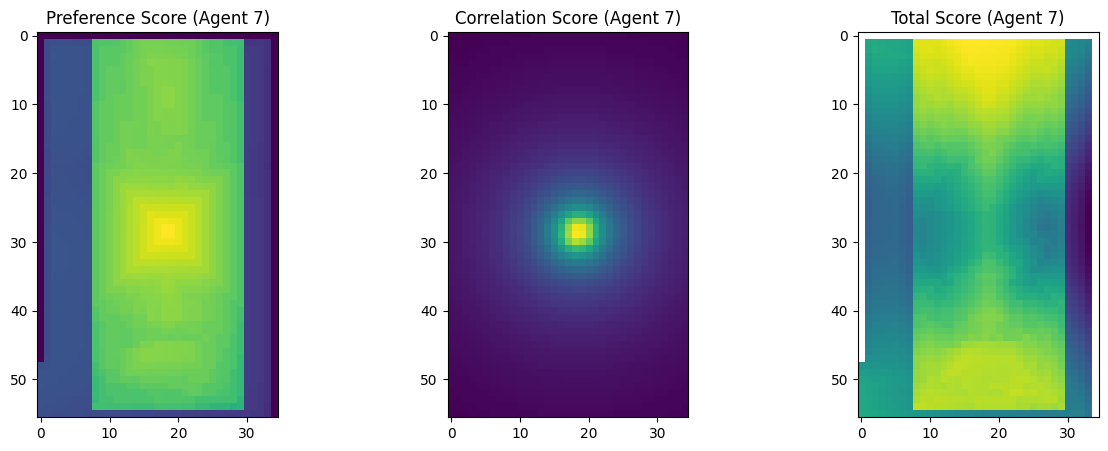

Agent 7:
Best location: (1, 15, 14)
Preference score at best location: 0.6417
Correlation score at best location: 0.0157
Total score at best location: 0.9930




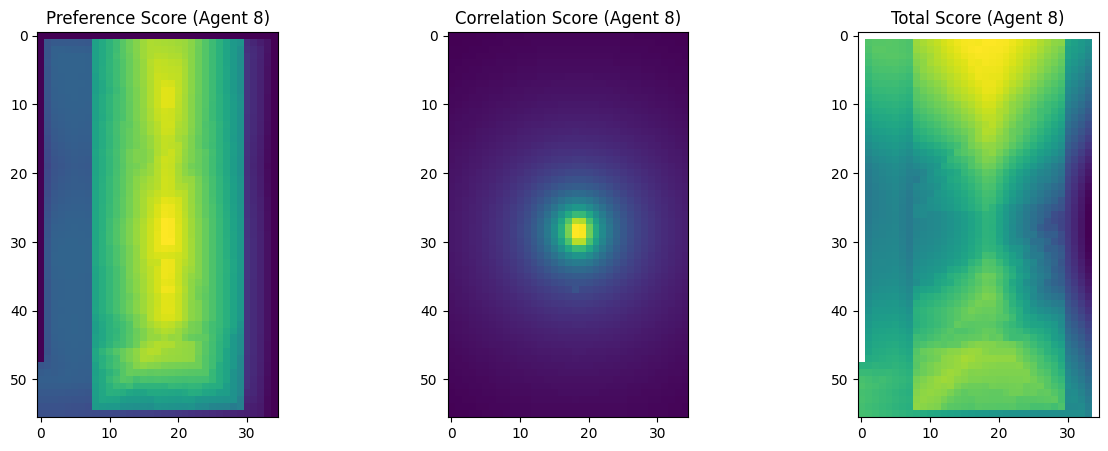

Agent 8:
Best location: (1, 18, 13)
Preference score at best location: 0.6399
Correlation score at best location: 0.0173
Total score at best location: 0.9923




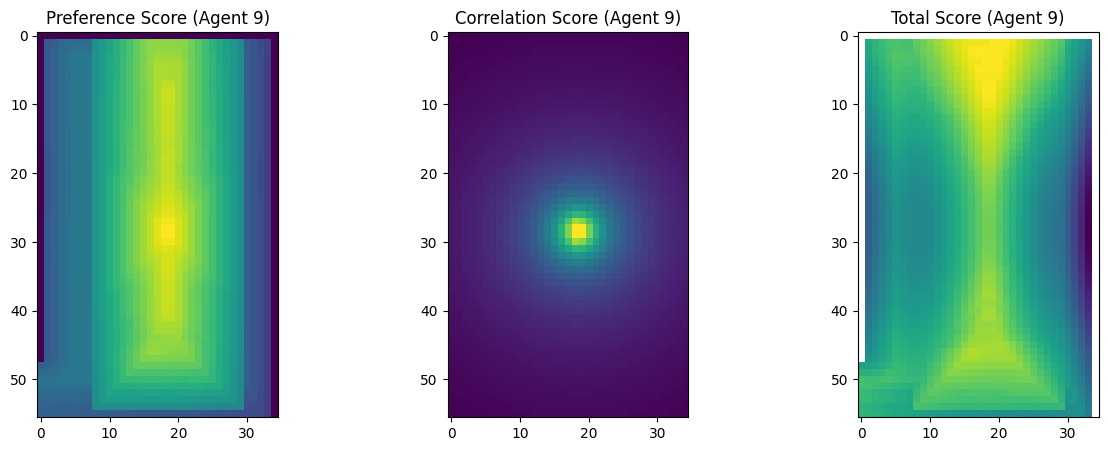

Agent 9:
Best location: (4, 18, 13)
Preference score at best location: 0.6762
Correlation score at best location: 0.0188
Total score at best location: 0.9927




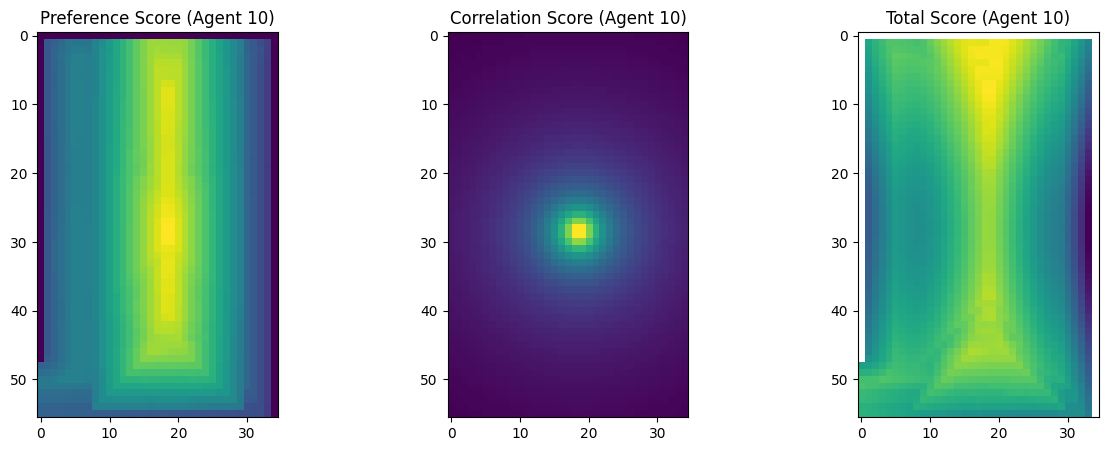

Agent 10:
Best location: (8, 18, 12)
Preference score at best location: 0.7321
Correlation score at best location: 0.0160
Total score at best location: 0.9950




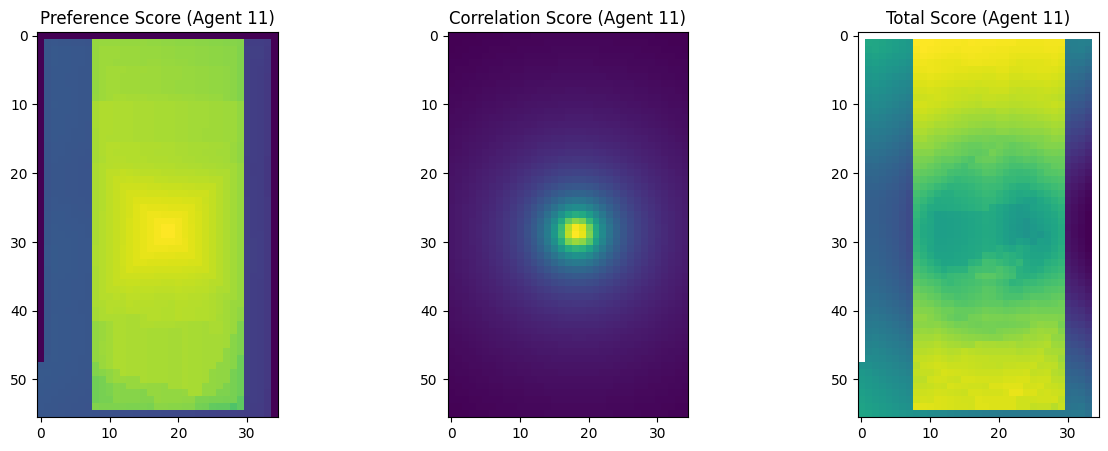

Agent 11:
Best location: (1, 9, 21)
Preference score at best location: 0.6656
Correlation score at best location: 0.0130
Total score at best location: 0.9947




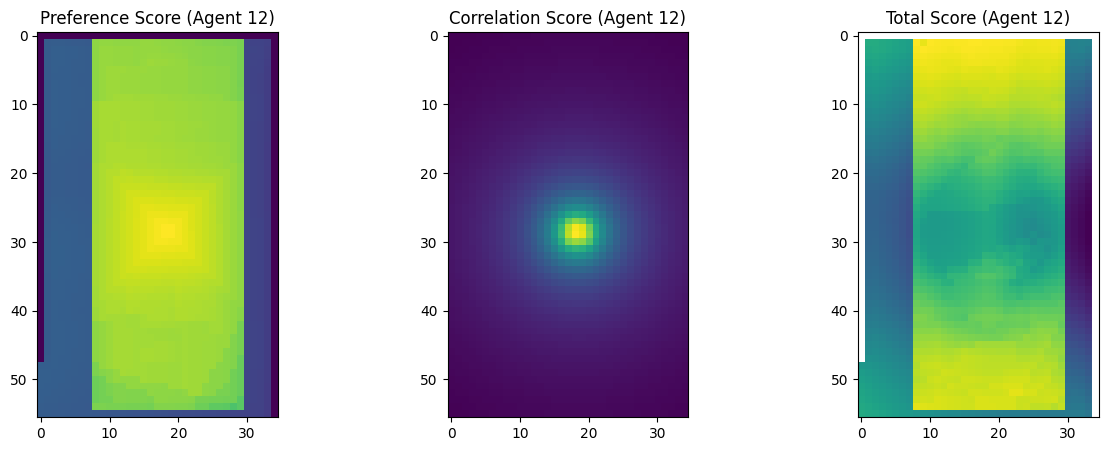

Agent 12:
Best location: (1, 8, 21)
Preference score at best location: 0.6445
Correlation score at best location: 0.0153
Total score at best location: 0.9933




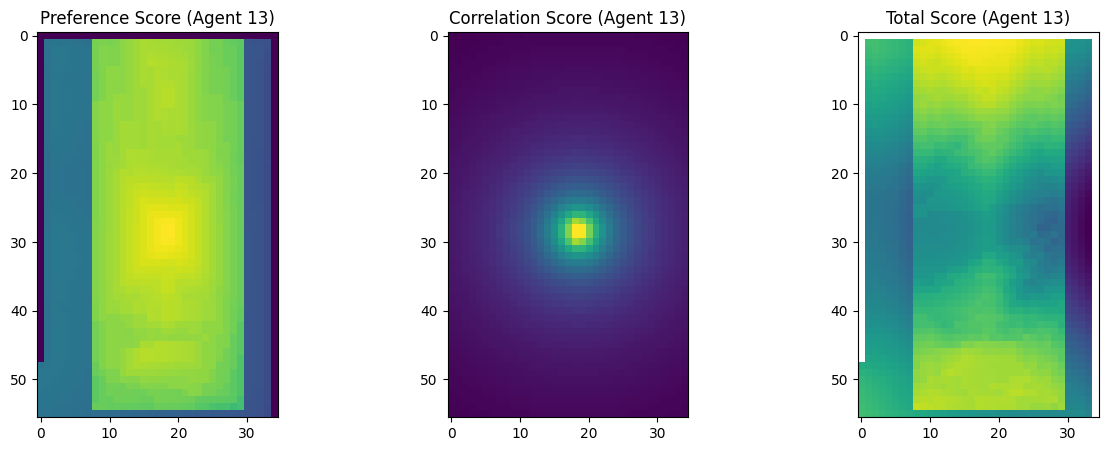

Agent 13:
Best location: (1, 16, 14)
Preference score at best location: 0.6254
Correlation score at best location: 0.0163
Total score at best location: 0.9924




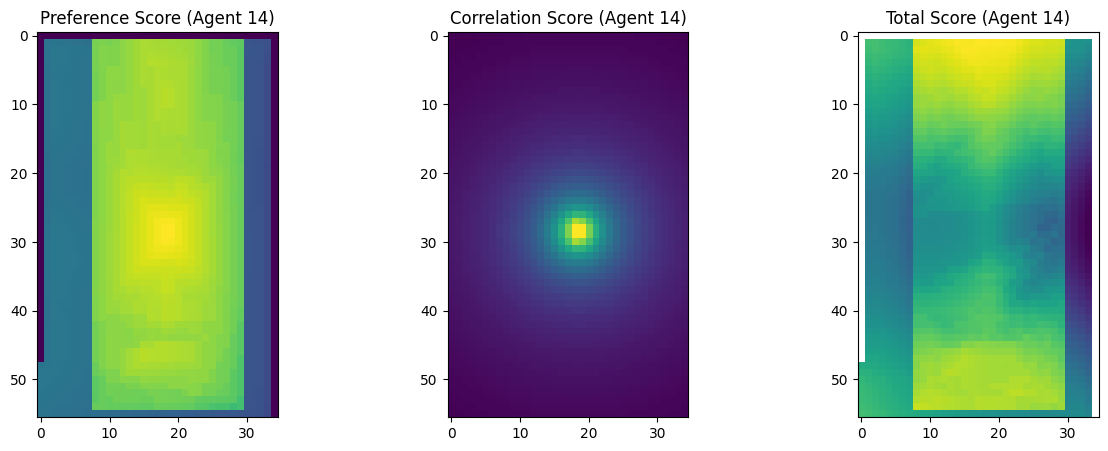

Agent 14:
Best location: (1, 17, 14)
Preference score at best location: 0.6234
Correlation score at best location: 0.0108
Total score at best location: 0.9949




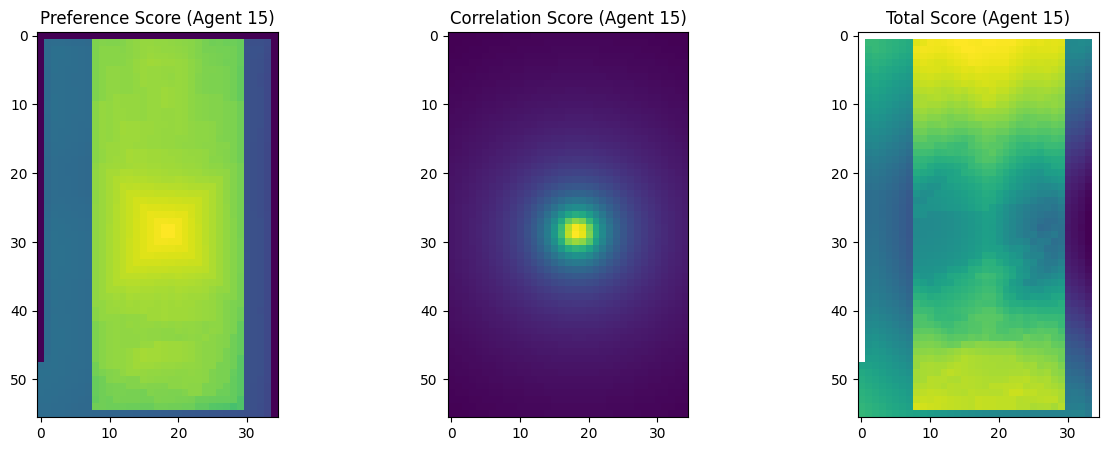

Agent 15:
Best location: (1, 18, 14)
Preference score at best location: 0.6205
Correlation score at best location: 0.0125
Total score at best location: 0.9940




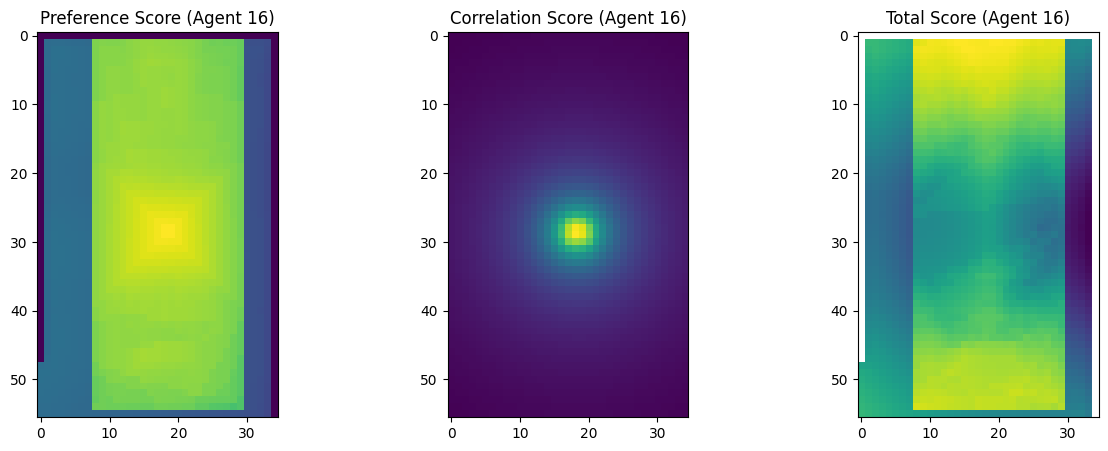

Agent 16:
Best location: (1, 14, 15)
Preference score at best location: 0.6196
Correlation score at best location: 0.0119
Total score at best location: 0.9943




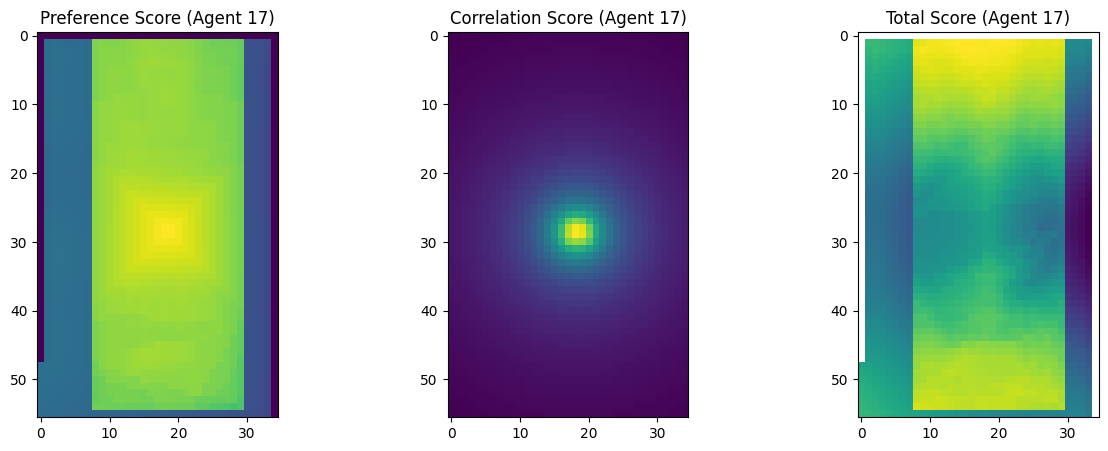

Agent 17:
Best location: (1, 19, 14)
Preference score at best location: 0.6186
Correlation score at best location: 0.0117
Total score at best location: 0.9944




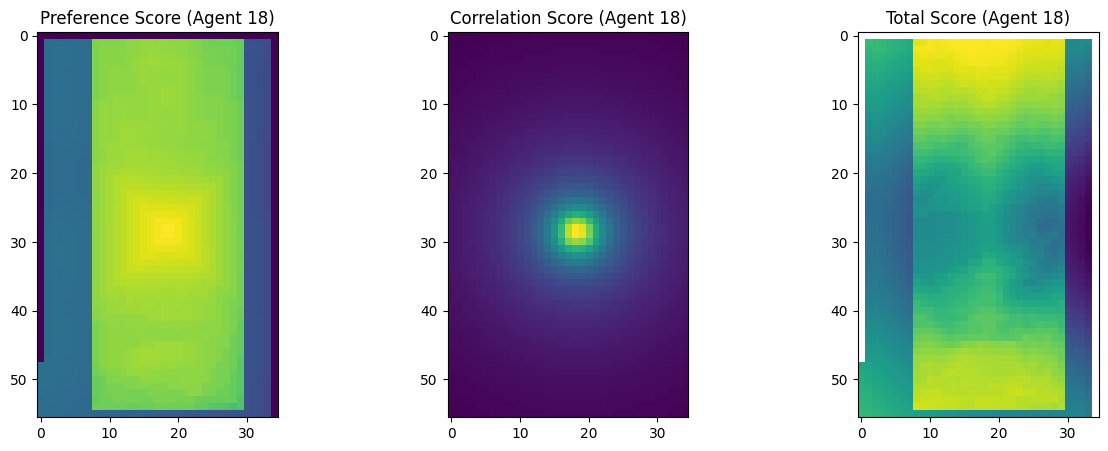

Agent 18:
Best location: (1, 14, 14)
Preference score at best location: 0.6151
Correlation score at best location: 0.0124
Total score at best location: 0.9940




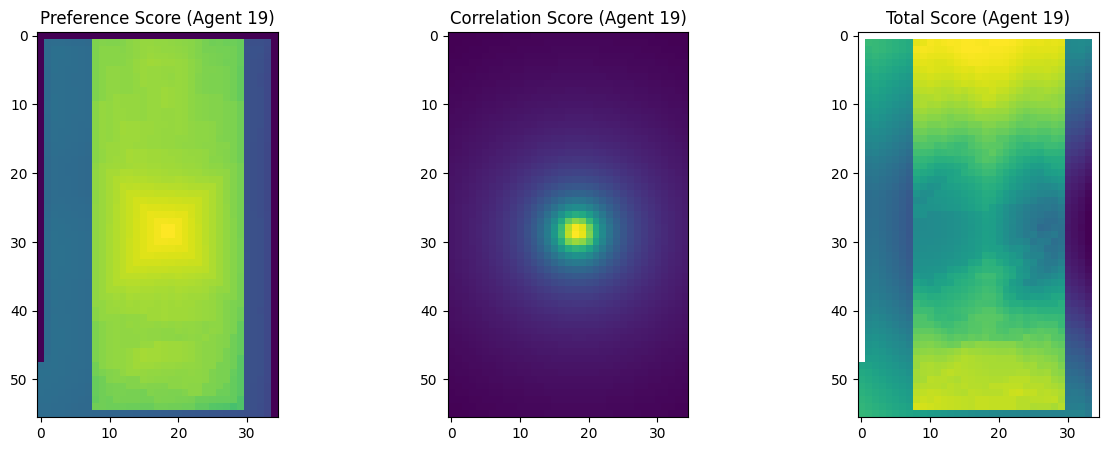

Agent 19:
Best location: (1, 15, 15)
Preference score at best location: 0.6188
Correlation score at best location: 0.0136
Total score at best location: 0.9935




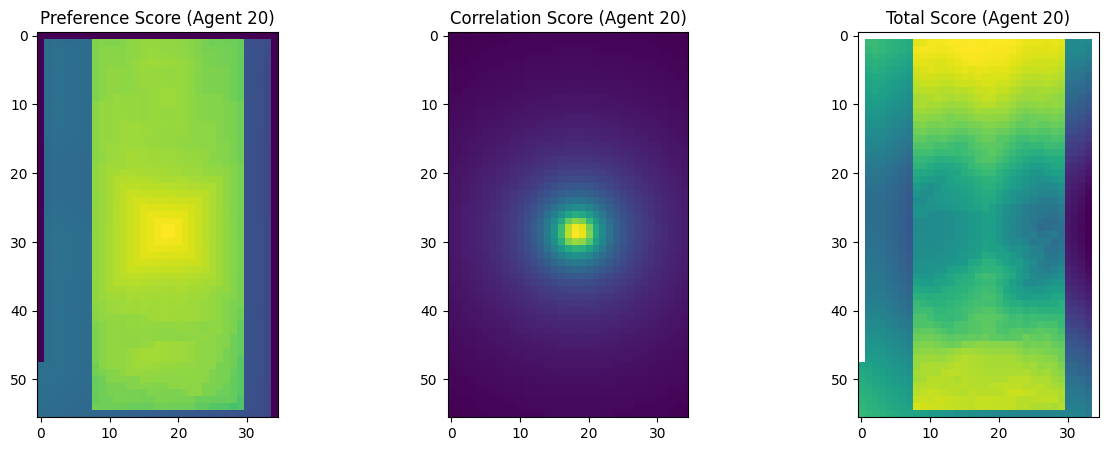

Agent 20:
Best location: (2, 16, 14)
Preference score at best location: 0.6263
Correlation score at best location: 0.0138
Total score at best location: 0.9935




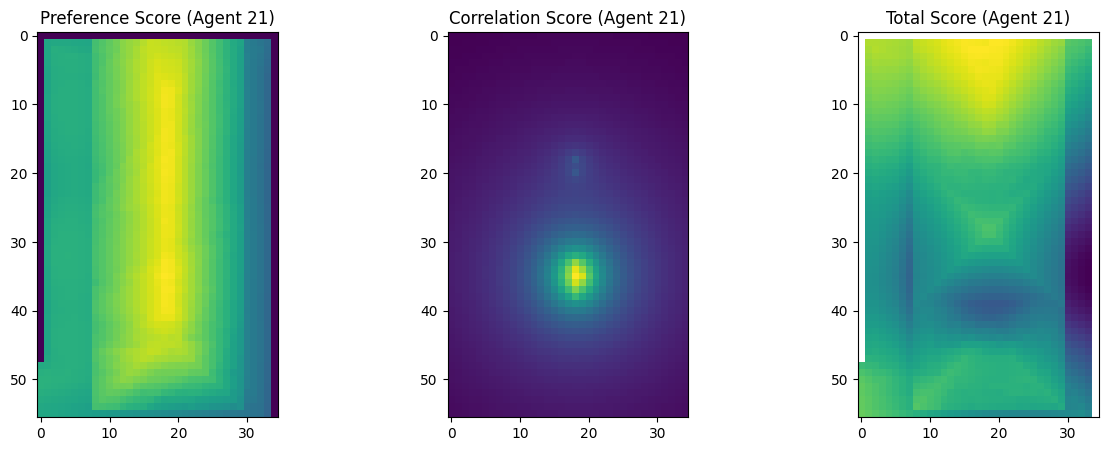

Agent 21:
Best location: (1, 19, 13)
Preference score at best location: 0.5923
Correlation score at best location: 0.0132
Total score at best location: 0.9931




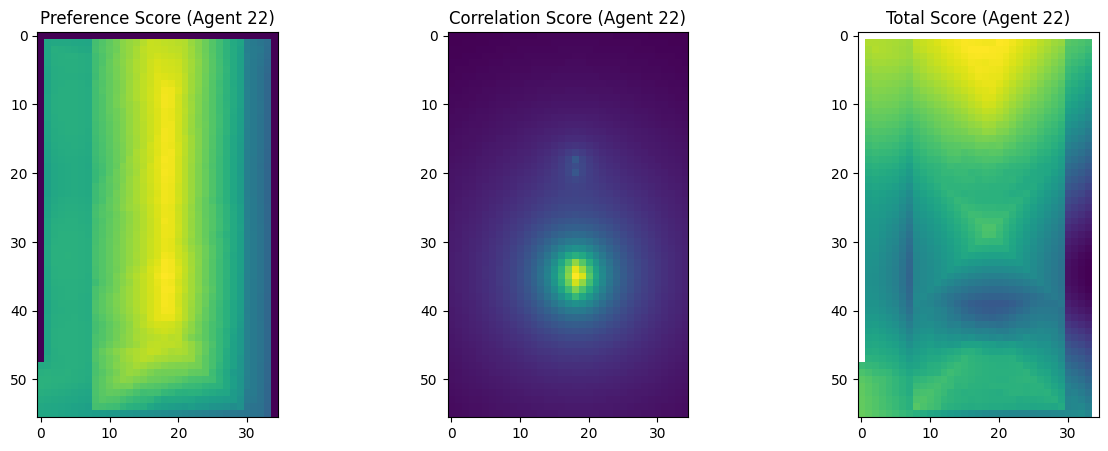

Agent 22:
Best location: (2, 17, 13)
Preference score at best location: 0.6015
Correlation score at best location: 0.0109
Total score at best location: 0.9945




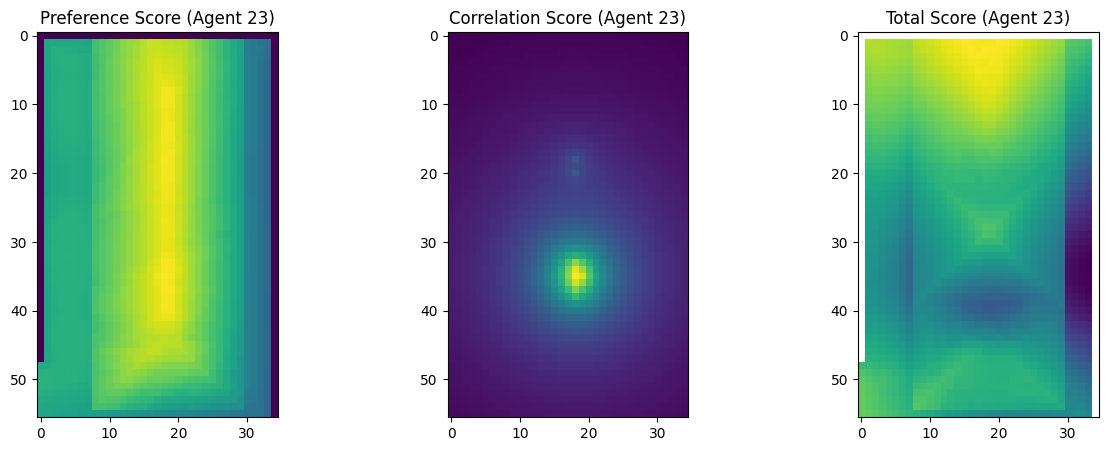

Agent 23:
Best location: (2, 16, 13)
Preference score at best location: 0.6005
Correlation score at best location: 0.0070
Total score at best location: 0.9965




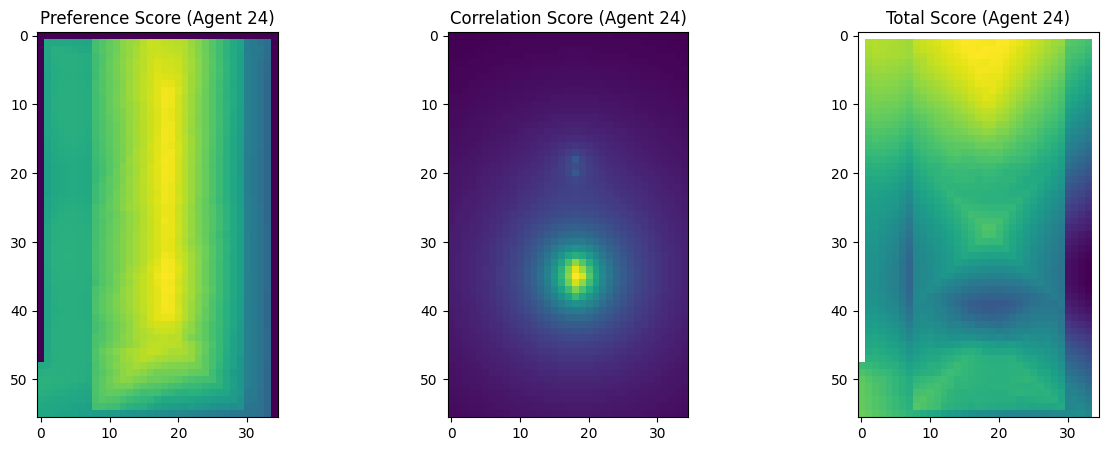

Agent 24:
Best location: (1, 20, 13)
Preference score at best location: 0.5890
Correlation score at best location: 0.0079
Total score at best location: 0.9958




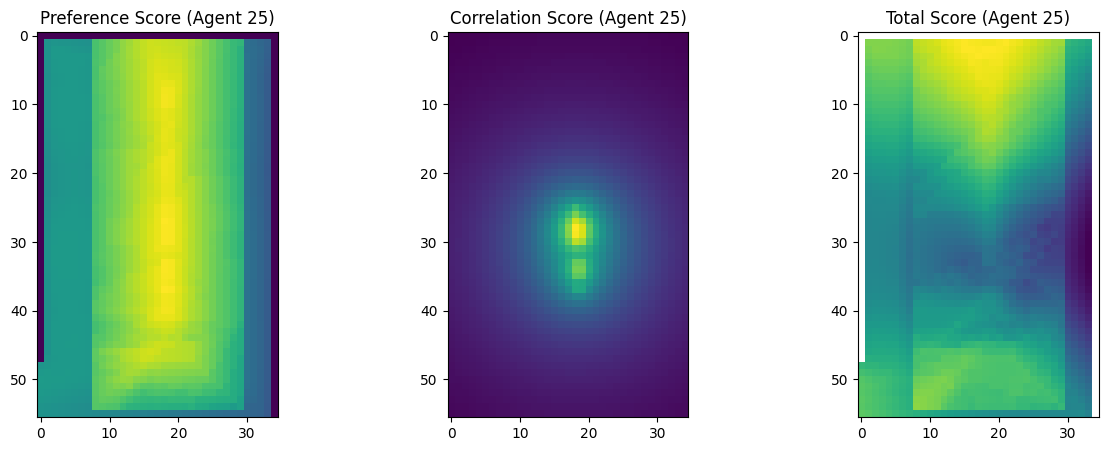

Agent 25:
Best location: (2, 18, 13)
Preference score at best location: 0.6164
Correlation score at best location: 0.0114
Total score at best location: 0.9945




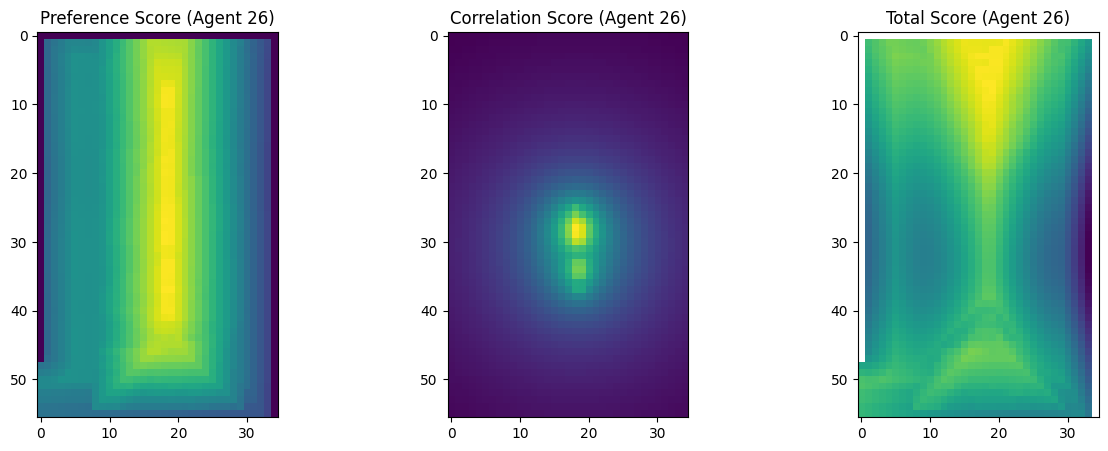

Agent 26:
Best location: (8, 19, 12)
Preference score at best location: 0.7217
Correlation score at best location: 0.0107
Total score at best location: 0.9965




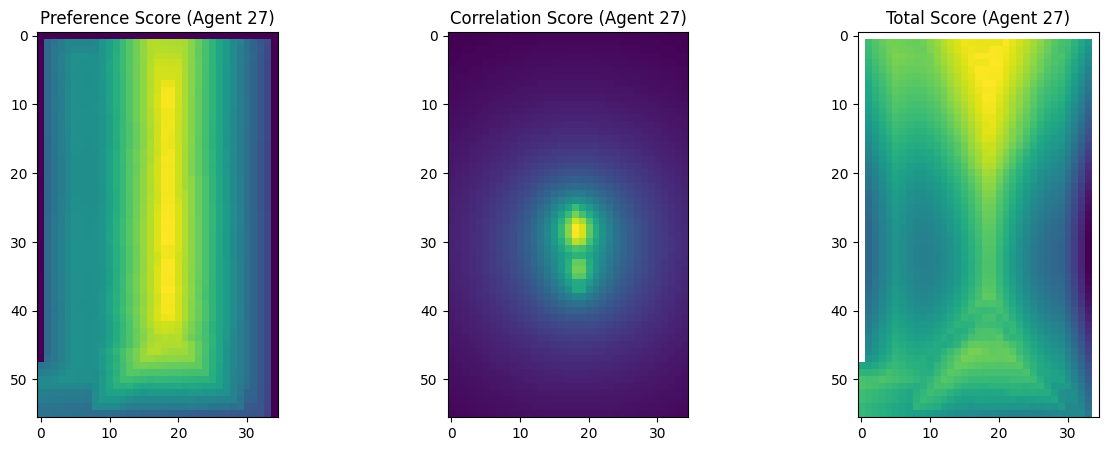

Agent 27:
Best location: (7, 18, 12)
Preference score at best location: 0.7105
Correlation score at best location: 0.0083
Total score at best location: 0.9972




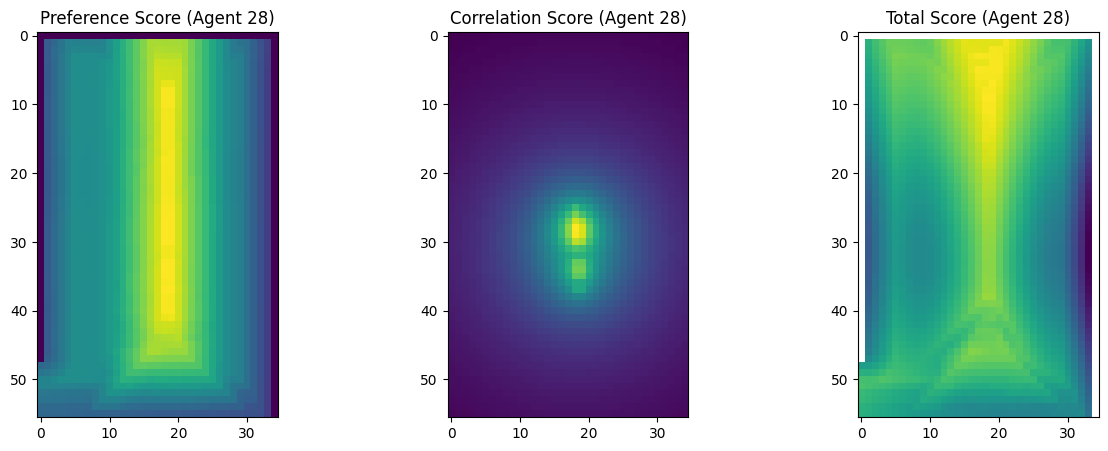

Agent 28:
Best location: (7, 19, 12)
Preference score at best location: 0.7386
Correlation score at best location: 0.0109
Total score at best location: 0.9967




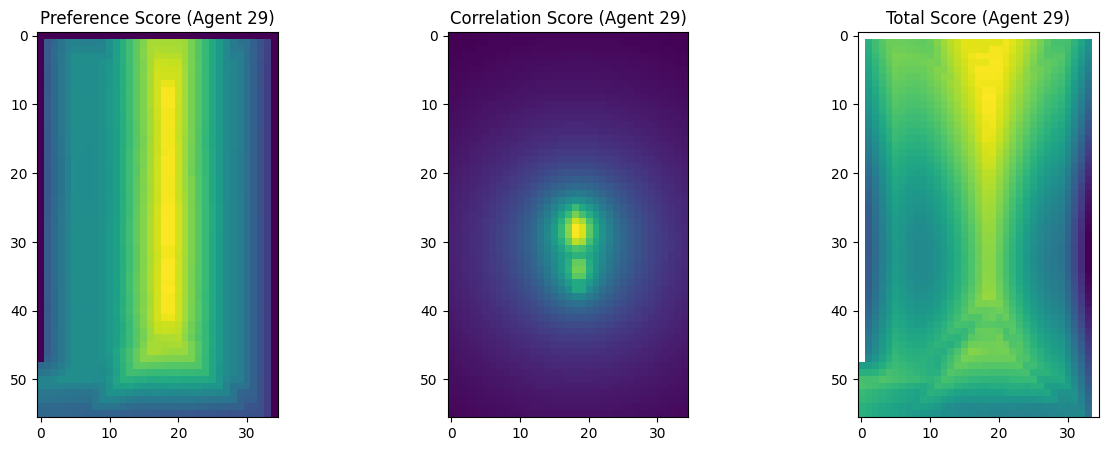

Agent 29:
Best location: (9, 18, 12)
Preference score at best location: 0.7570
Correlation score at best location: 0.0120
Total score at best location: 0.9967




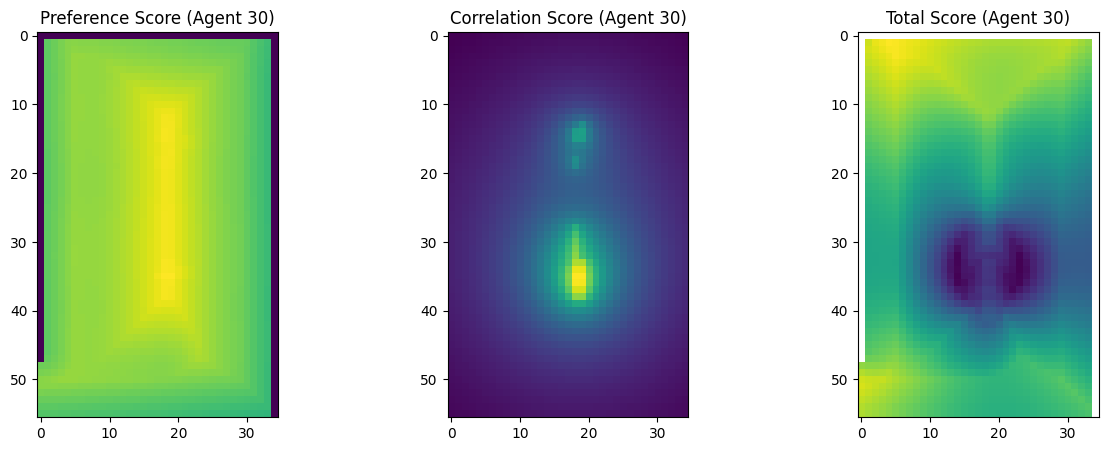

Agent 30:
Best location: (1, 4, 0)
Preference score at best location: 0.6274
Correlation score at best location: 0.0056
Total score at best location: 0.9974




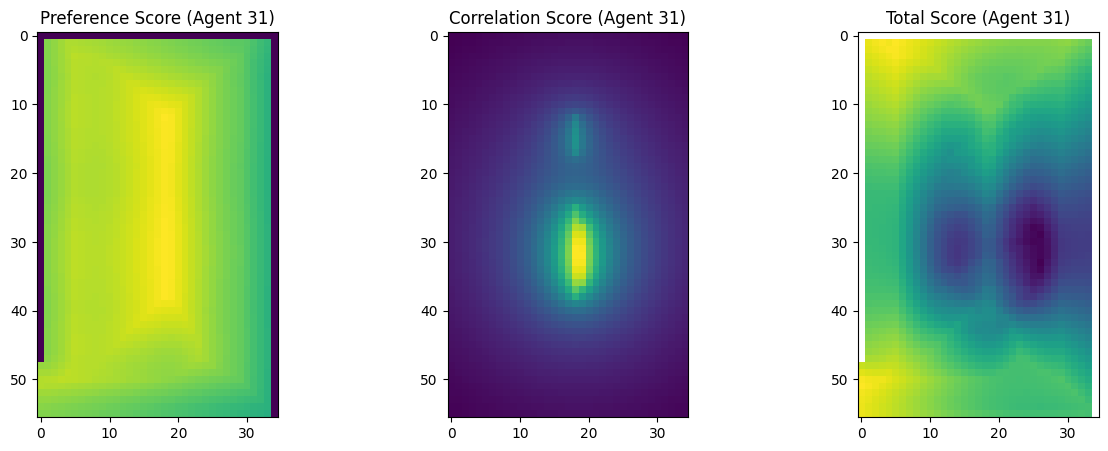

Agent 31:
Best location: (51, 0, 0)
Preference score at best location: 0.6638
Correlation score at best location: 0.0056
Total score at best location: 0.9977




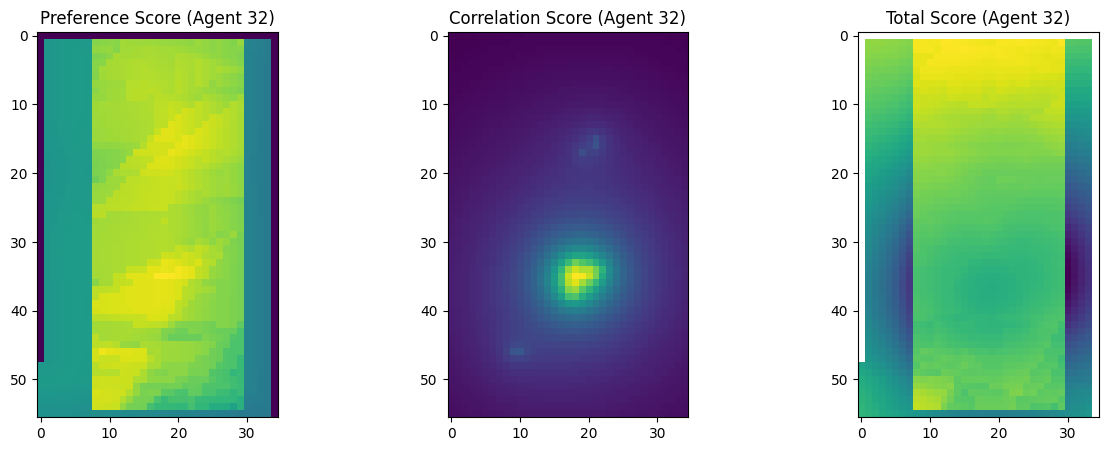

Agent 32:
Best location: (1, 12, 9)
Preference score at best location: 0.6314
Correlation score at best location: 0.0065
Total score at best location: 0.9970




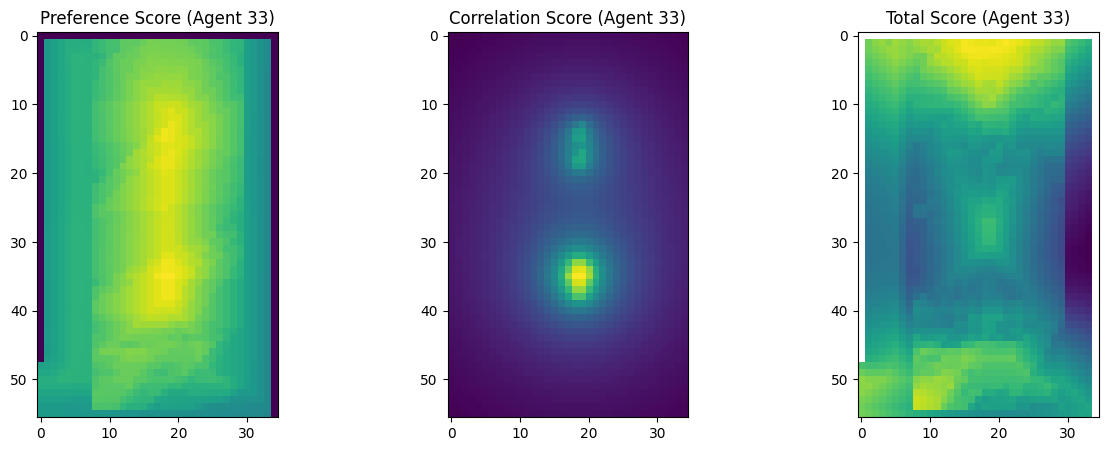

Agent 33:
Best location: (1, 21, 13)
Preference score at best location: 0.6115
Correlation score at best location: 0.0074
Total score at best location: 0.9964




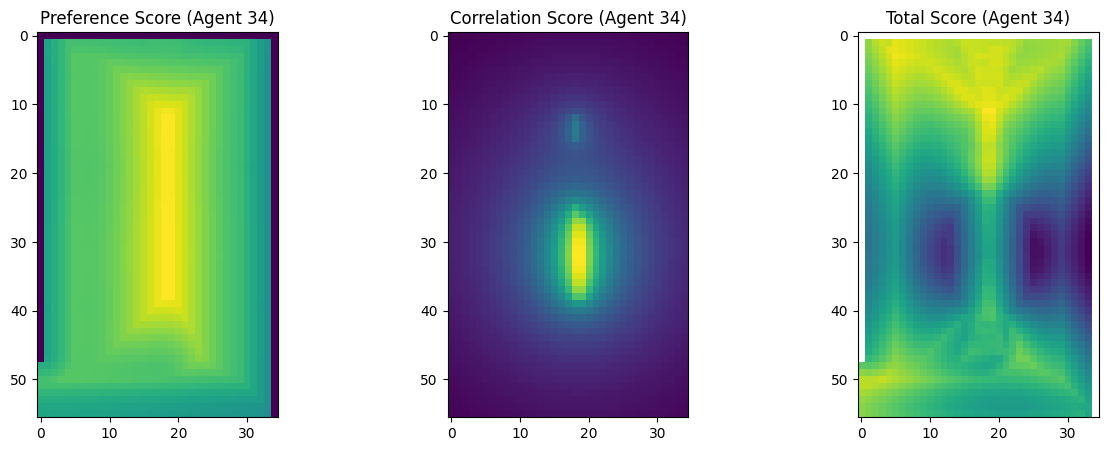

Agent 34:
Best location: (11, 19, 5)
Preference score at best location: 0.7753
Correlation score at best location: 0.0106
Total score at best location: 0.9973




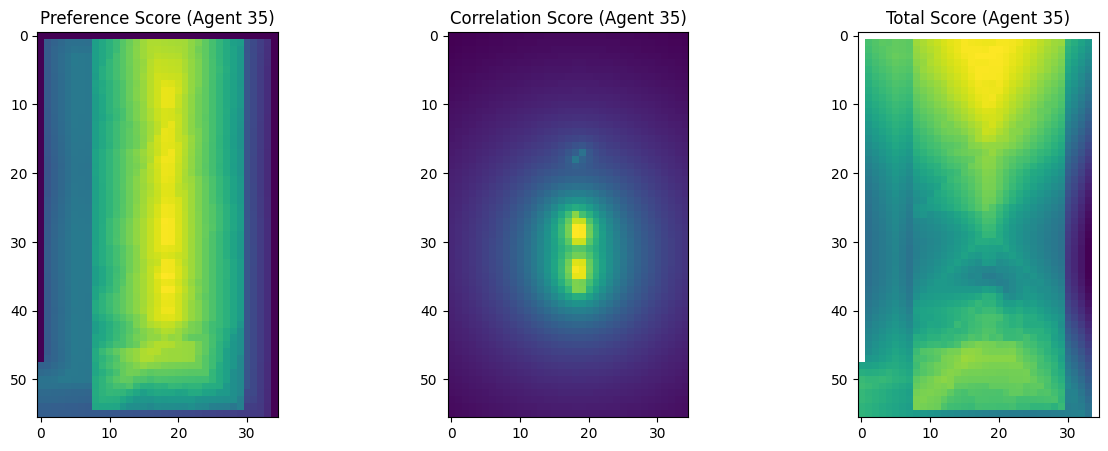

Agent 35:
Best location: (3, 17, 13)
Preference score at best location: 0.6823
Correlation score at best location: 0.0076
Total score at best location: 0.9971




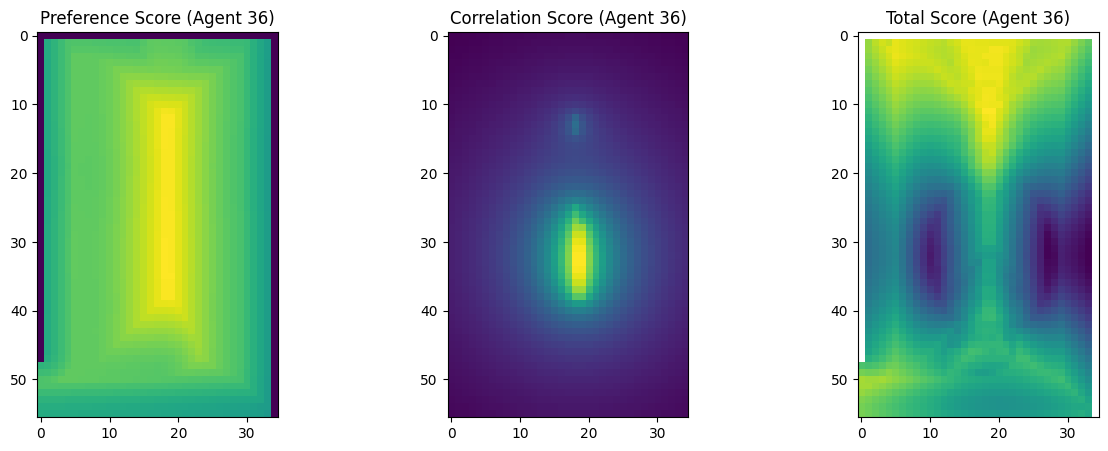

Agent 36:
Best location: (11, 18, 6)
Preference score at best location: 0.7399
Correlation score at best location: 0.0129
Total score at best location: 0.9961




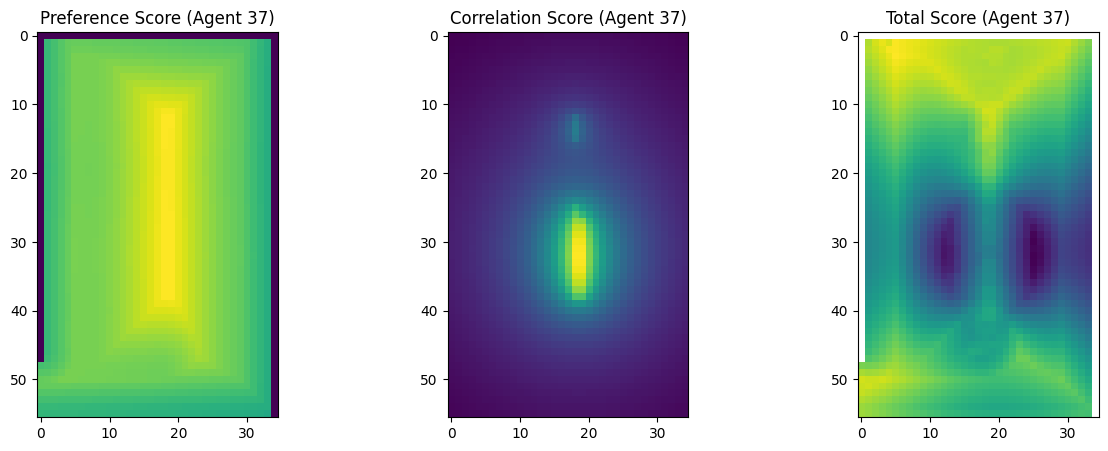

Agent 37:
Best location: (3, 5, 0)
Preference score at best location: 0.6422
Correlation score at best location: 0.0094
Total score at best location: 0.9958




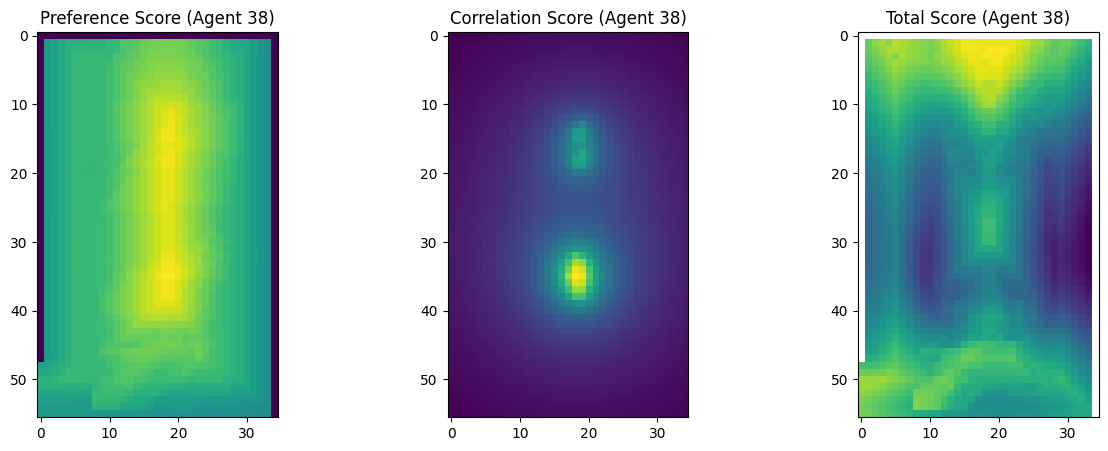

Agent 38:
Best location: (2, 19, 13)
Preference score at best location: 0.6175
Correlation score at best location: 0.0074
Total score at best location: 0.9964




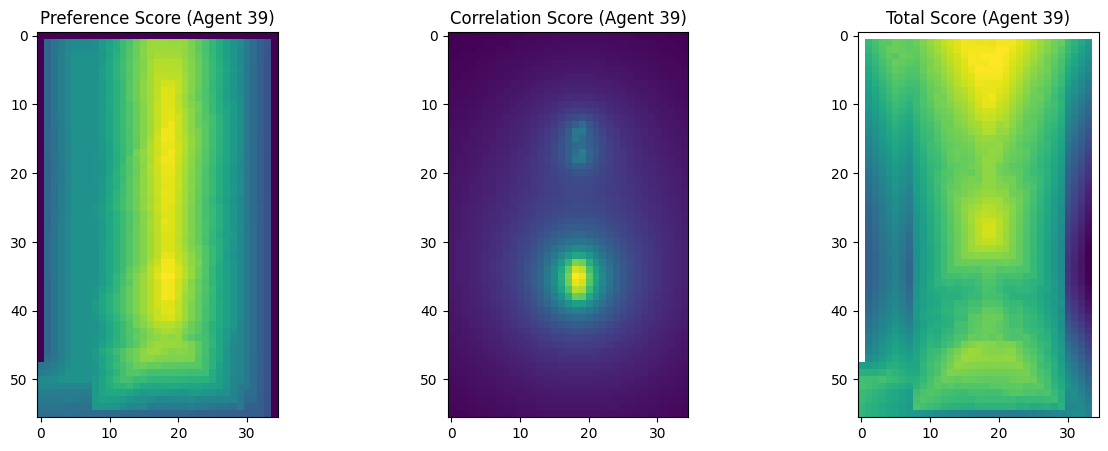

Agent 39:
Best location: (3, 18, 13)
Preference score at best location: 0.6713
Correlation score at best location: 0.0083
Total score at best location: 0.9967




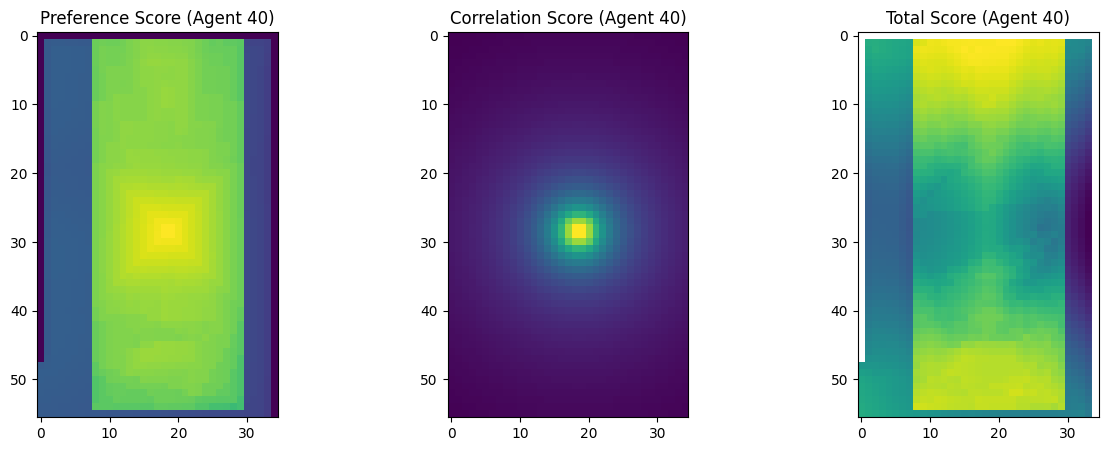

Agent 40:
Best location: (1, 20, 14)
Preference score at best location: 0.6324
Correlation score at best location: 0.0075
Total score at best location: 0.9966




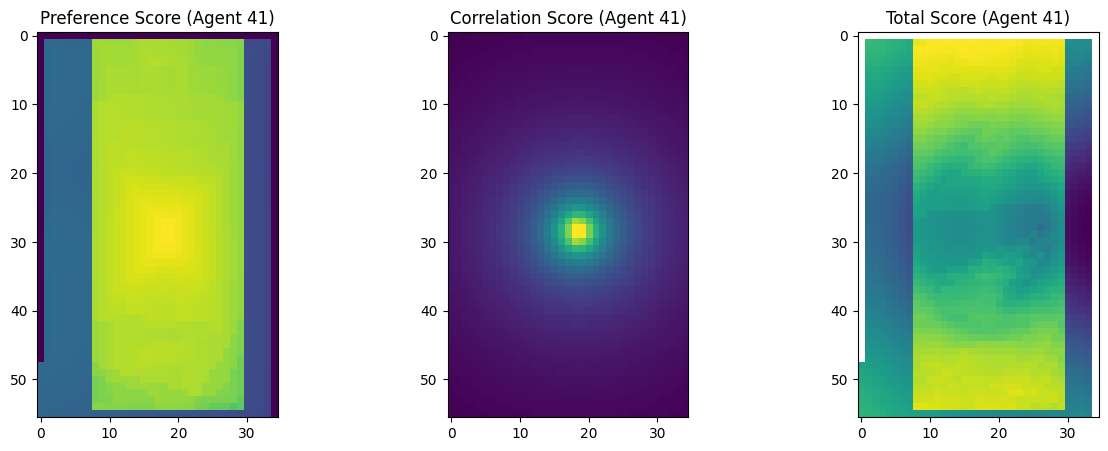

Agent 41:
Best location: (1, 10, 21)
Preference score at best location: 0.6267
Correlation score at best location: 0.0075
Total score at best location: 0.9965




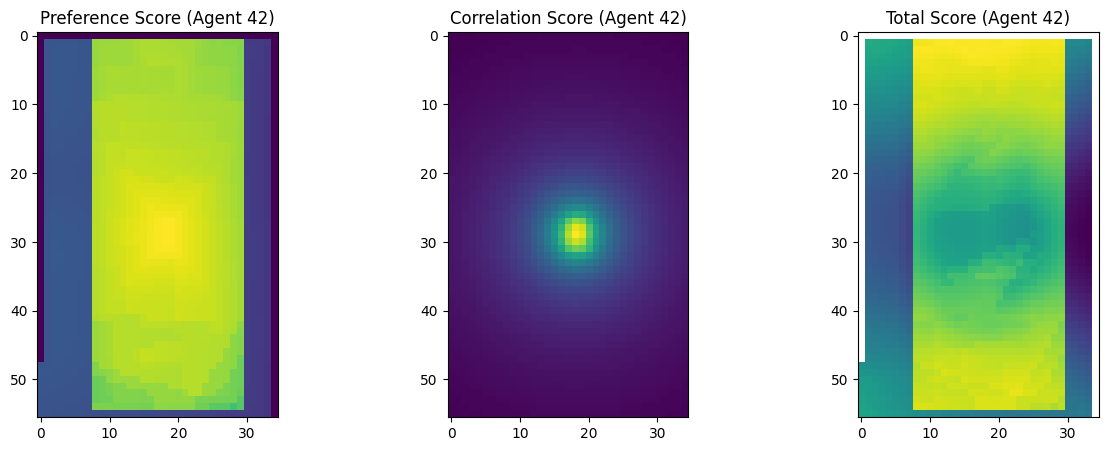

Agent 42:
Best location: (2, 15, 14)
Preference score at best location: 0.6771
Correlation score at best location: 0.0092
Total score at best location: 0.9964




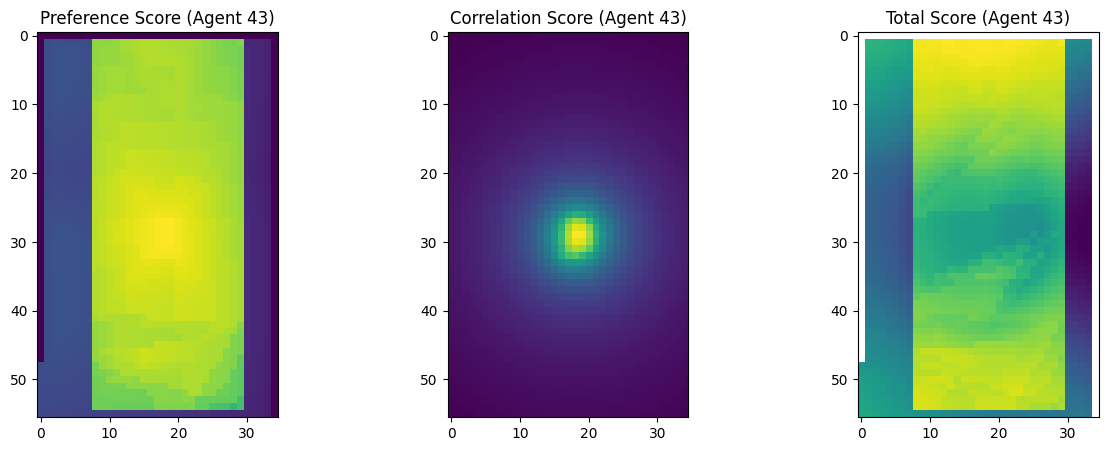

Agent 43:
Best location: (1, 13, 14)
Preference score at best location: 0.6678
Correlation score at best location: 0.0088
Total score at best location: 0.9965




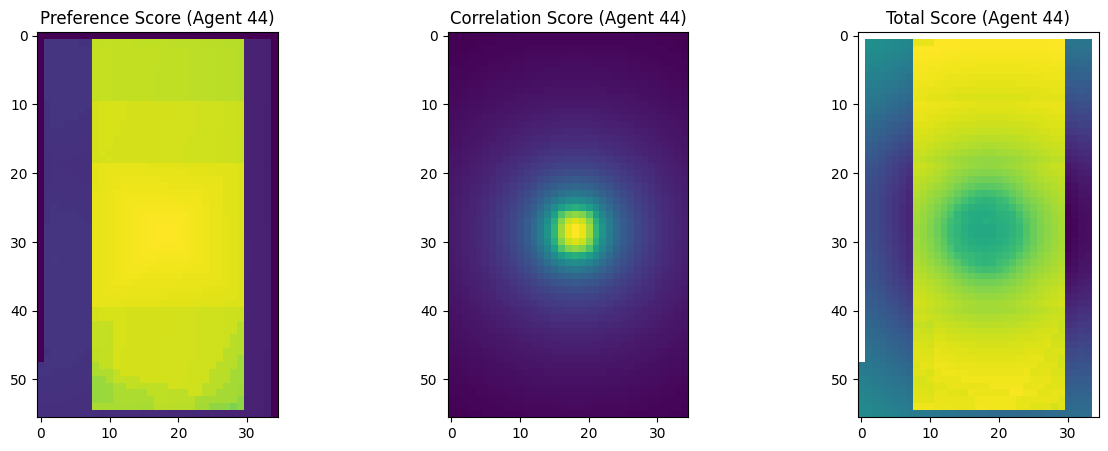

Agent 44:
Best location: (2, 9, 21)
Preference score at best location: 0.7823
Correlation score at best location: 0.0060
Total score at best location: 0.9985




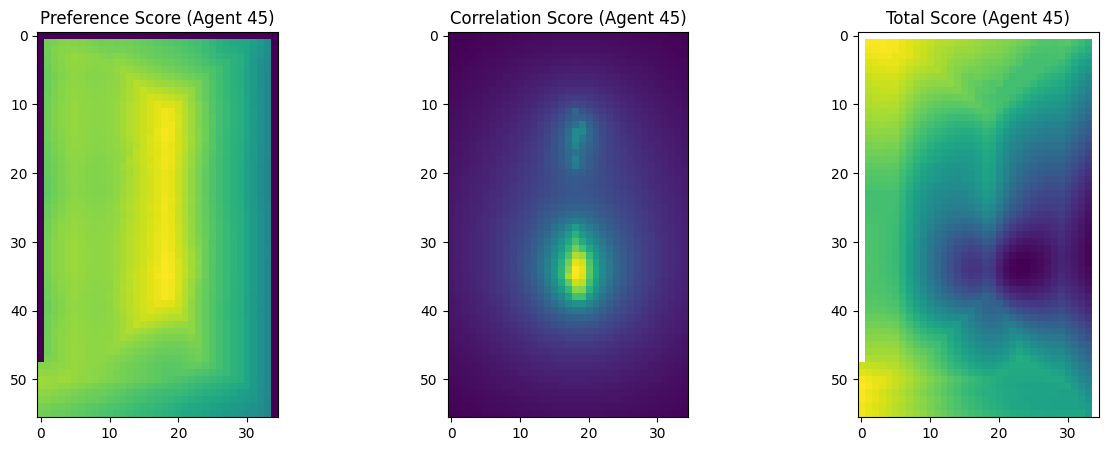

Agent 45:
Best location: (51, 0, 1)
Preference score at best location: 0.6332
Correlation score at best location: 0.0049
Total score at best location: 0.9978




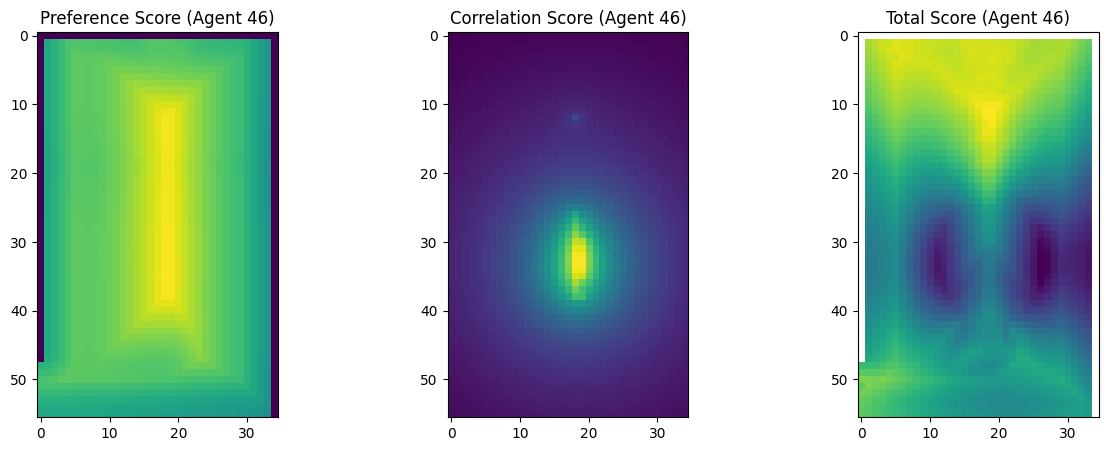

Agent 46:
Best location: (11, 18, 5)
Preference score at best location: 0.7482
Correlation score at best location: 0.0070
Total score at best location: 0.9980




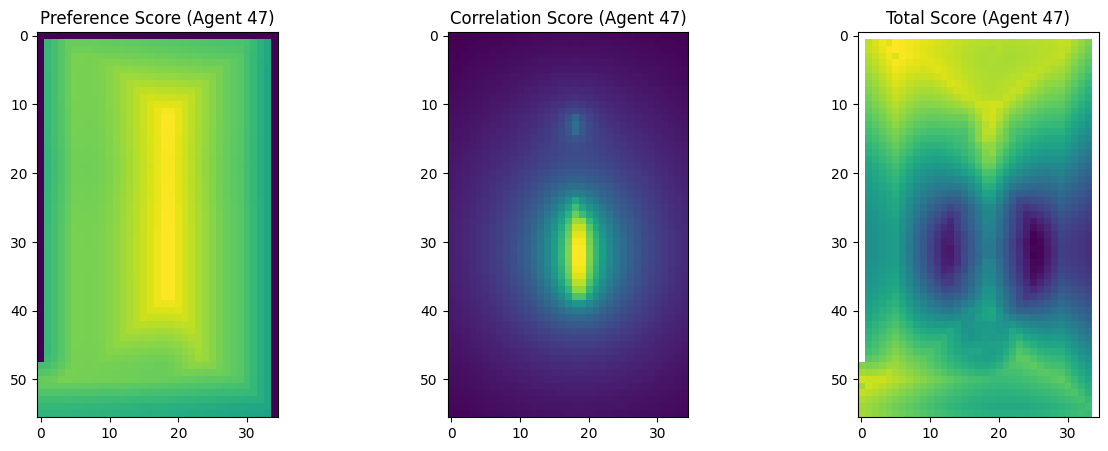

Agent 47:
Best location: (1, 5, 0)
Preference score at best location: 0.6301
Correlation score at best location: 0.0103
Total score at best location: 0.9952




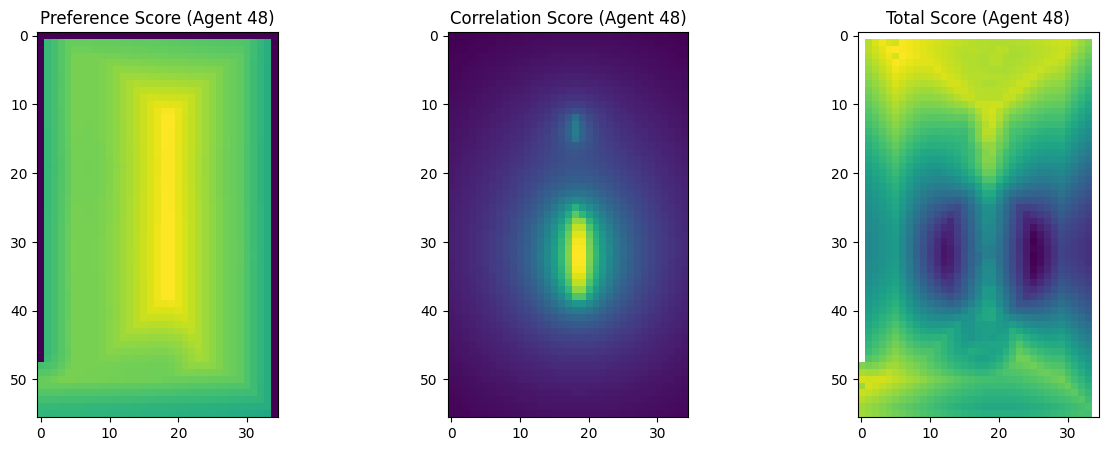

Agent 48:
Best location: (2, 5, 0)
Preference score at best location: 0.6301
Correlation score at best location: 0.0105
Total score at best location: 0.9952




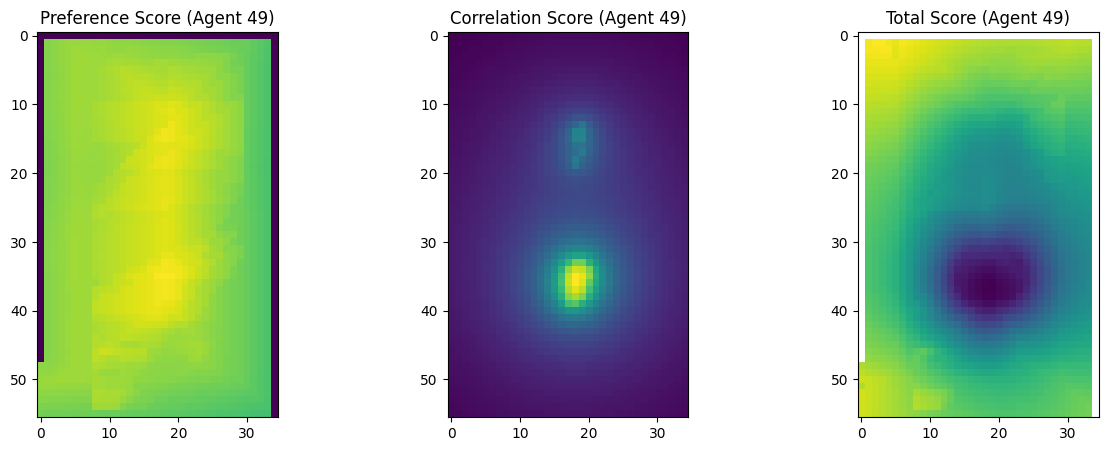

Agent 49:
Best location: (1, 3, 0)
Preference score at best location: 0.6143
Correlation score at best location: 0.0102
Total score at best location: 0.9950




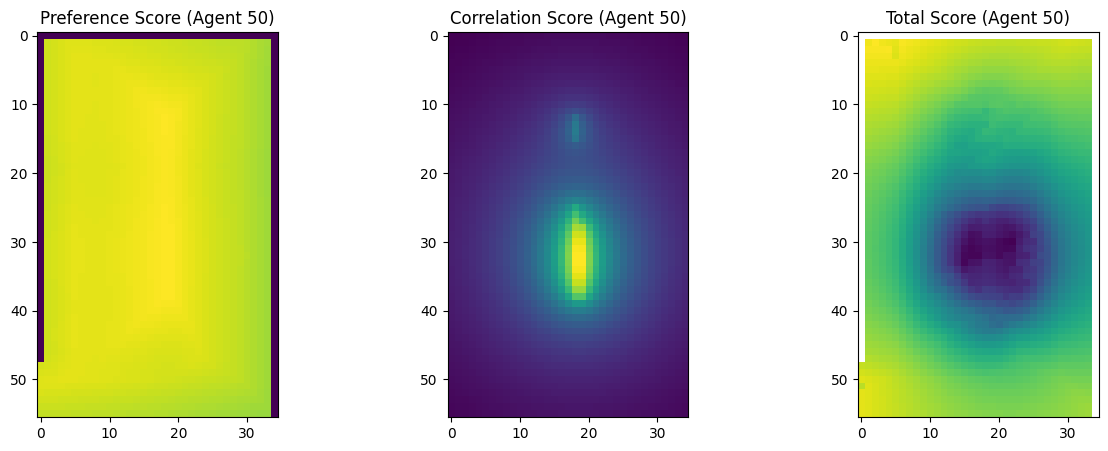

Agent 50:
Best location: (1, 2, 0)
Preference score at best location: 0.6915
Correlation score at best location: 0.0105
Total score at best location: 0.9961




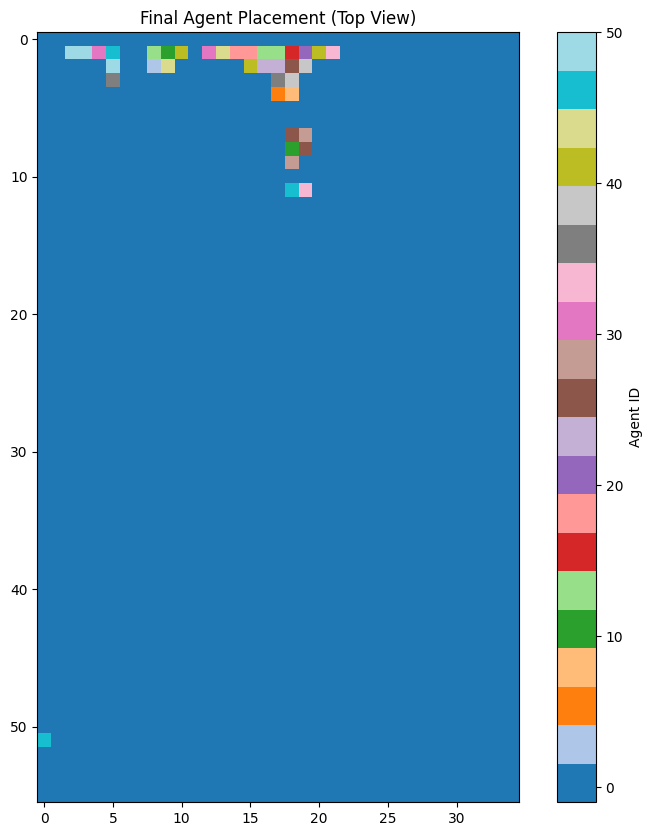

In [11]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

agn_num = len(program_prefs)
occ_lattice = avail_lattice * 0 - 1
init_avail_lattice = np.copy(avail_lattice)

def calculate_pref_score(a_id):
    pref_lattice = np.zeros_like(avail_lattice, dtype=float)
    for f, w in program_prefs.iloc[a_id].items():
        pref_lattice += fields[f] * w
    return pref_lattice / sum(program_prefs.iloc[a_id])

def calculate_corr_score(a_id, placed_agents, top_locations):
    corr_lattice = np.zeros_like(avail_lattice, dtype=float)
    if placed_agents:
        x, y, z = np.meshgrid(np.arange(avail_lattice.shape[0]),
                              np.arange(avail_lattice.shape[1]),
                              np.arange(avail_lattice.shape[2]),
                              indexing='ij')
        for loc in top_locations:
            for other_agent, other_loc in placed_agents:
                correlation = program_mtx.iloc[a_id, other_agent]
                distances = np.sqrt((x - loc[0])**2 + (y - loc[1])**2 + (z - loc[2])**2)
                corr_lattice += correlation / (distances + 1)
        corr_lattice /= len(placed_agents) * len(top_locations)
    return corr_lattice

def find_best_location(a_id, placed_agents):
    pref_lattice = calculate_pref_score(a_id)
    
    # 선호도 점수 상위 30개 위치 찾기
    top_30_indices = np.argpartition(pref_lattice.flatten(), -30)[-30:]
    top_30_locations = np.array(np.unravel_index(top_30_indices, pref_lattice.shape)).T
    
    # 상위 30개 위치를 기반으로 상관관계 점수 계산
    corr_lattice = calculate_corr_score(a_id, placed_agents, top_30_locations)
    
    # 최종 점수 계산
    total_score = pref_lattice * corr_lattice
    total_score[init_avail_lattice == 0] = -np.inf
    best_location = np.unravel_index(np.argmax(total_score), total_score.shape)
    
    # 결과 시각화
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(np.max(pref_lattice, axis=2), cmap='viridis')
    axs[0].set_title(f'Preference Score (Agent {a_id})')
    axs[1].imshow(np.max(corr_lattice, axis=2), cmap='viridis')
    axs[1].set_title(f'Correlation Score (Agent {a_id})')
    axs[2].imshow(np.max(total_score, axis=2), cmap='viridis')
    axs[2].set_title(f'Total Score (Agent {a_id})')
    plt.show()
    
    print(f"Agent {a_id}:")
    print(f"Best location: {best_location}")
    print(f"Preference score at best location: {pref_lattice[best_location]:.4f}")
    print(f"Correlation score at best location: {corr_lattice[best_location]:.4f}")
    print(f"Total score at best location: {total_score[best_location]:.4f}")
    print("\n")
    
    return best_location, total_score[best_location]

# 에이전트 배치
agn_locs = []
for a_id in range(agn_num):
    best_location, best_score = find_best_location(a_id, agn_locs)
    agn_locs.append((a_id, best_location))
    init_avail_lattice[best_location] = 0
    occ_lattice[best_location] = a_id

# 최종 배치 시각화
plt.figure(figsize=(10, 10))
plt.imshow(np.max(occ_lattice, axis=2), cmap='tab20')
plt.colorbar(label='Agent ID')
plt.title('Final Agentnt ID')
plt.title('Final Agent Placement (Top View)')
plt.show()

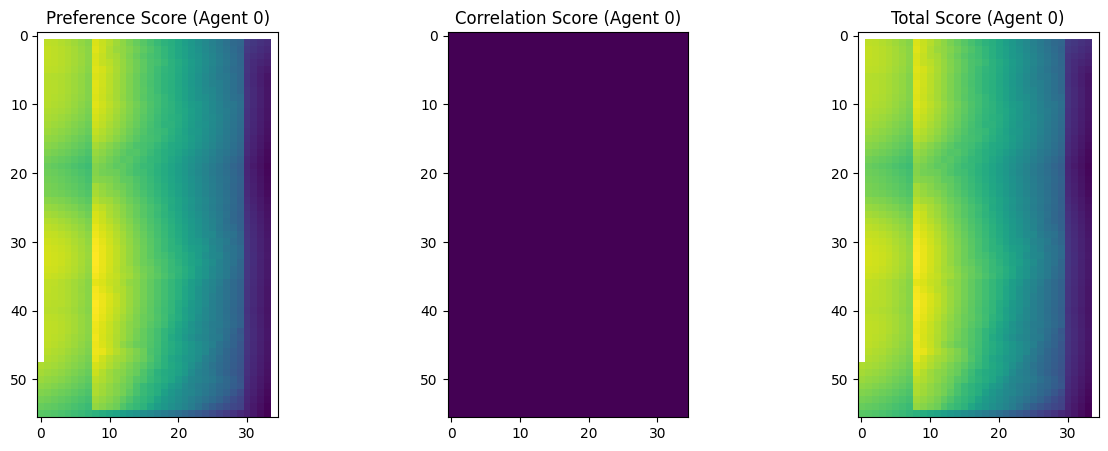

Agent 0:
Best location: (39, 8, 5)
Preference score at best location: 0.7904
Correlation score at best location: 0.0000
Total score at best location: 0.7904




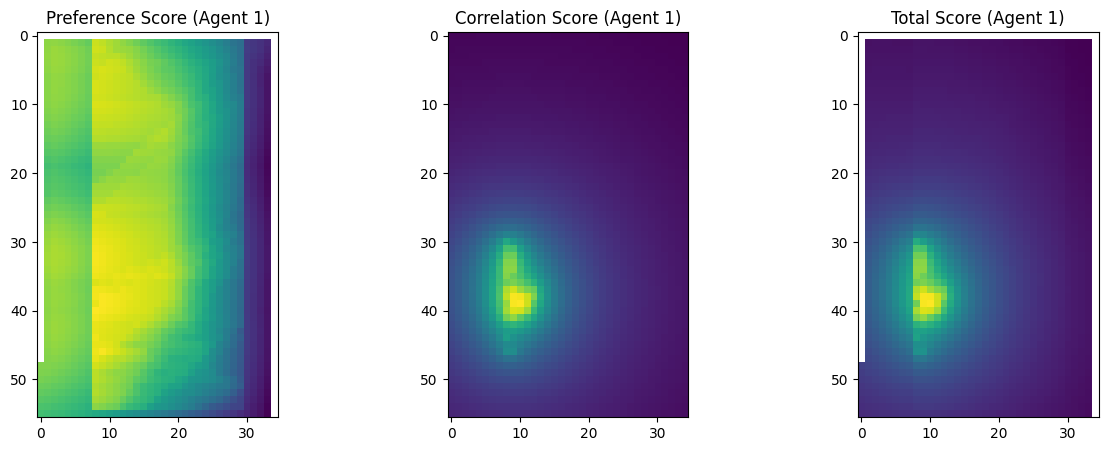

Agent 1:
Best location: (39, 10, 5)
Preference score at best location: 0.7247
Correlation score at best location: 7.8560
Total score at best location: 8.5807




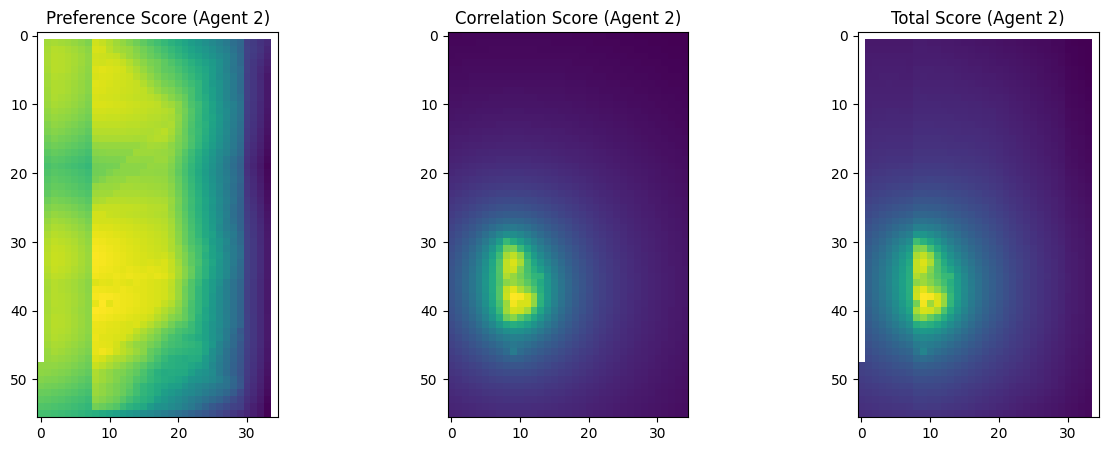

Agent 2:
Best location: (38, 9, 5)
Preference score at best location: 0.7300
Correlation score at best location: 4.6431
Total score at best location: 5.3731




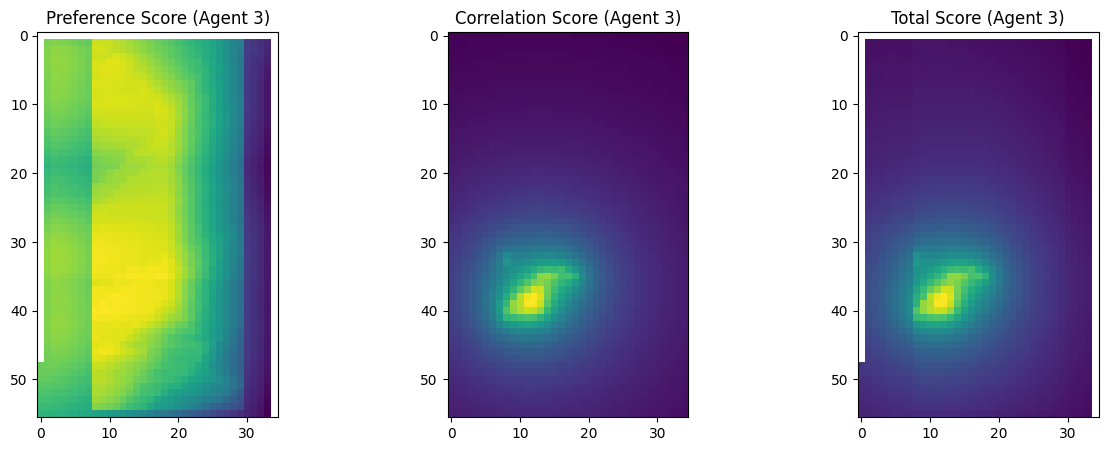

Agent 3:
Best location: (38, 12, 5)
Preference score at best location: 0.6527
Correlation score at best location: 5.9548
Total score at best location: 6.6075




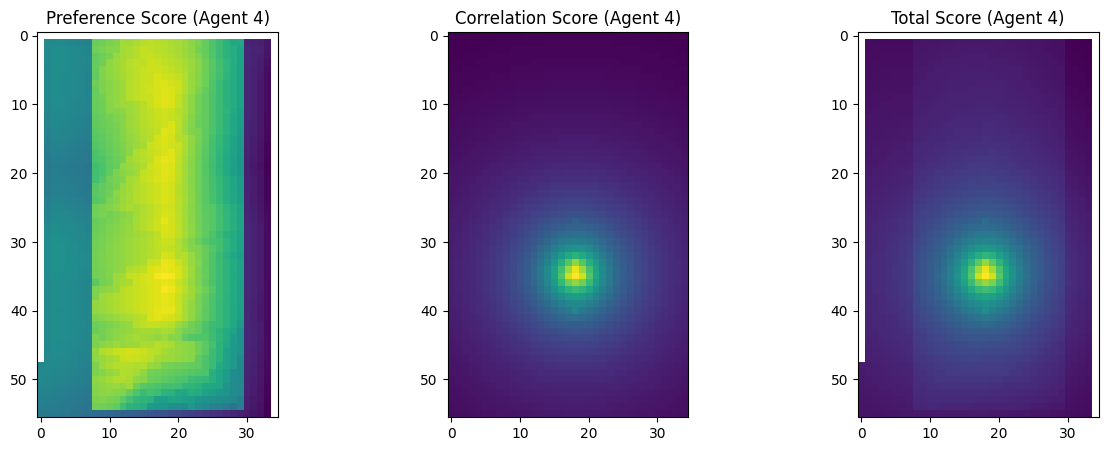

Agent 4:
Best location: (35, 18, 7)
Preference score at best location: 0.6541
Correlation score at best location: 5.2650
Total score at best location: 5.9191




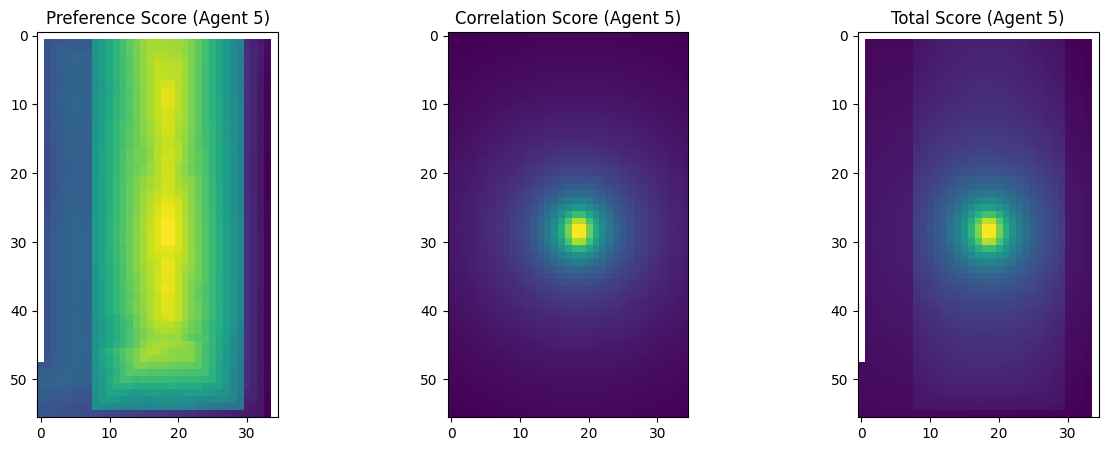

Agent 5:
Best location: (28, 18, 18)
Preference score at best location: 0.6953
Correlation score at best location: 5.3387
Total score at best location: 6.0340




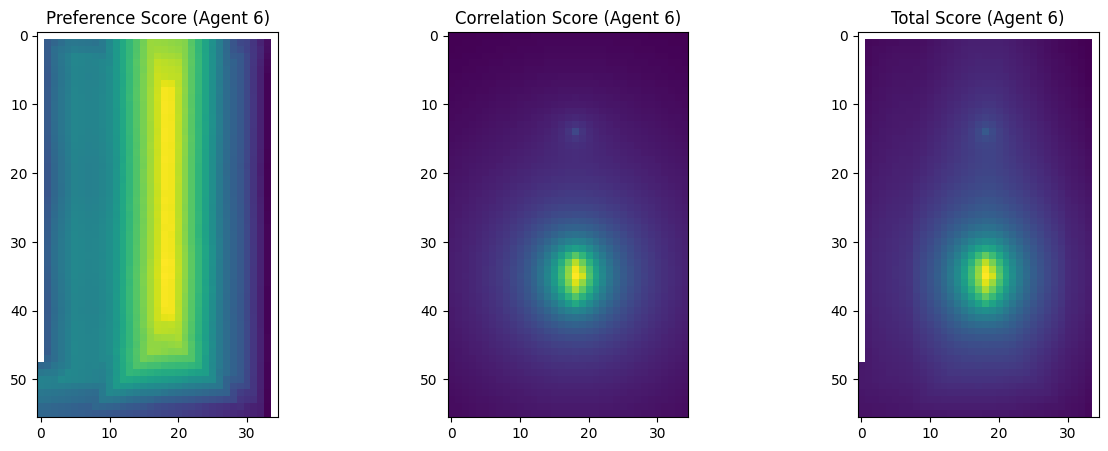

Agent 6:
Best location: (35, 18, 9)
Preference score at best location: 0.6985
Correlation score at best location: 4.7599
Total score at best location: 5.4584




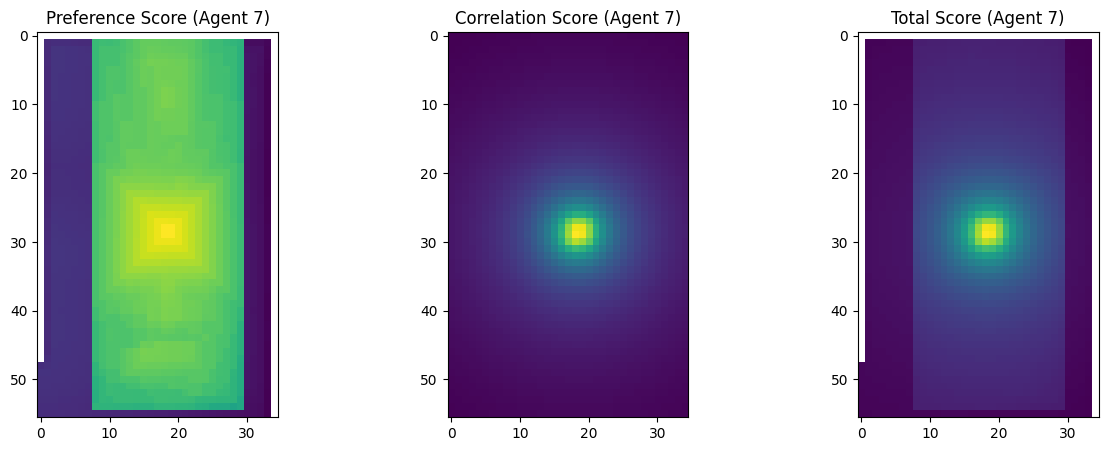

Agent 7:
Best location: (29, 18, 22)
Preference score at best location: 0.7785
Correlation score at best location: 5.6160
Total score at best location: 6.3945




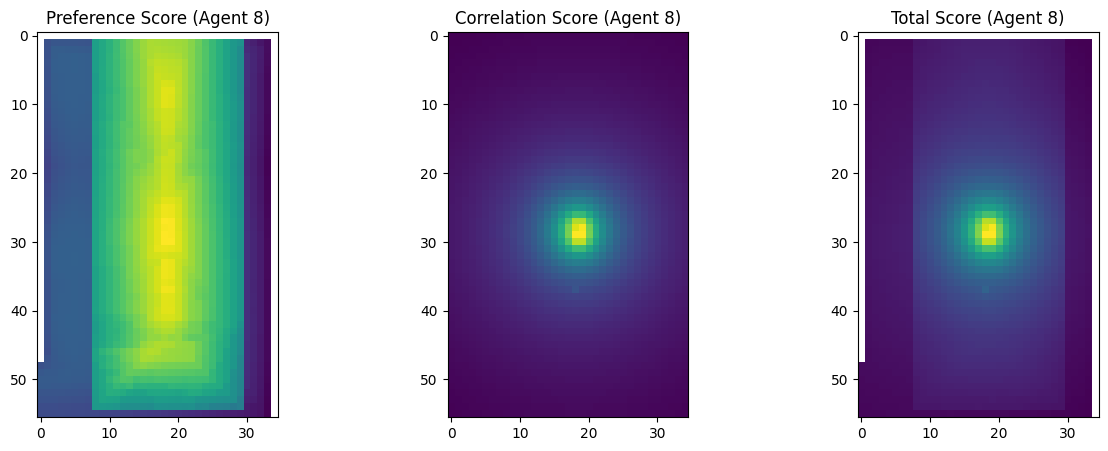

Agent 8:
Best location: (29, 19, 18)
Preference score at best location: 0.7030
Correlation score at best location: 5.6129
Total score at best location: 6.3159




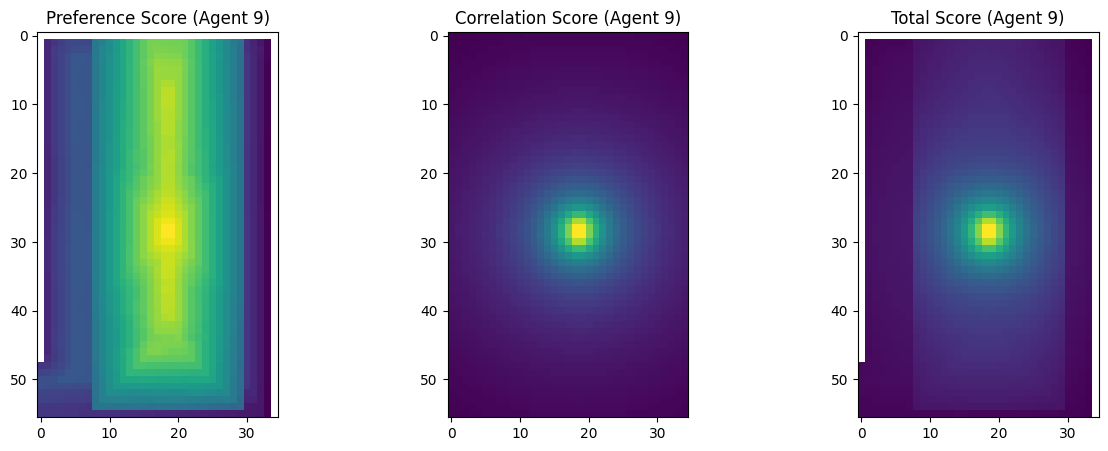

Agent 9:
Best location: (28, 19, 20)
Preference score at best location: 0.7618
Correlation score at best location: 5.5200
Total score at best location: 6.2818




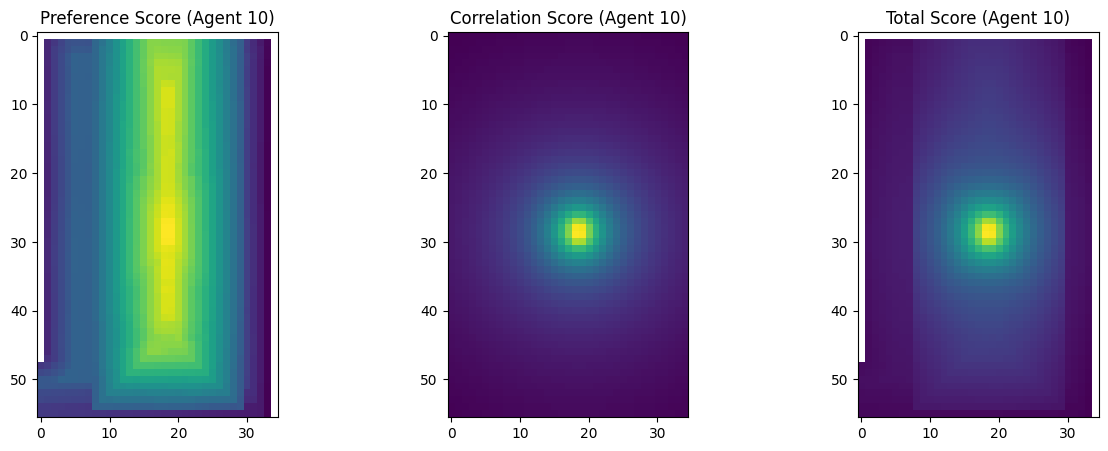

Agent 10:
Best location: (29, 18, 19)
Preference score at best location: 0.7644
Correlation score at best location: 3.8975
Total score at best location: 4.6619




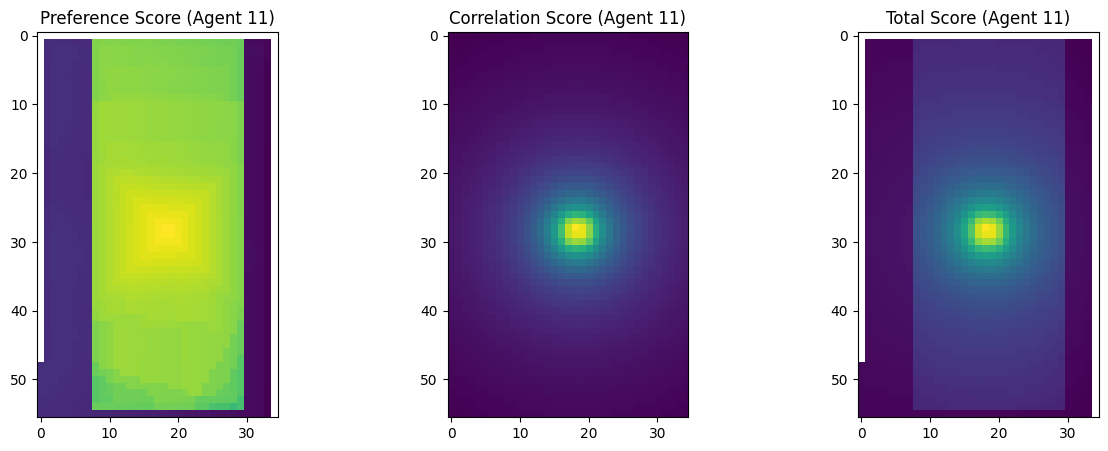

Agent 11:
Best location: (28, 18, 22)
Preference score at best location: 0.7729
Correlation score at best location: 4.6233
Total score at best location: 5.3962




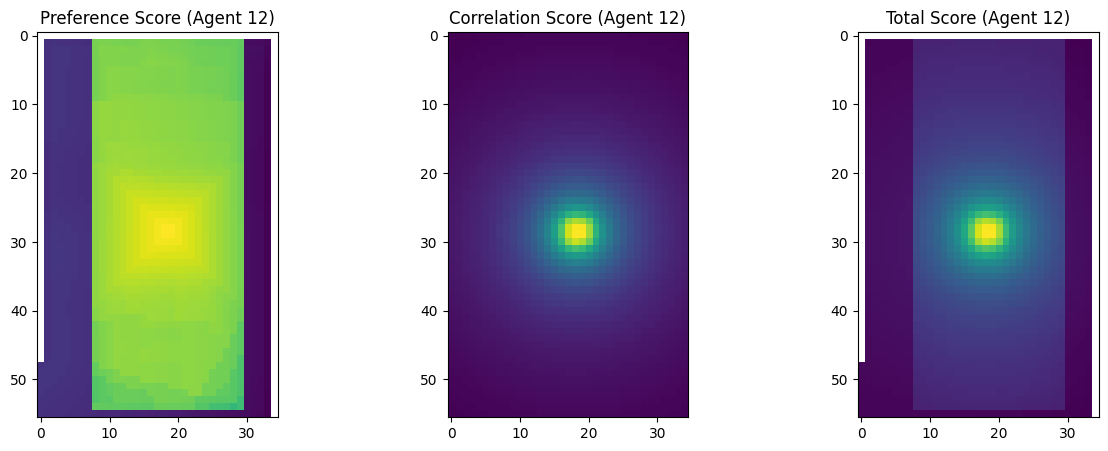

Agent 12:
Best location: (29, 18, 23)
Preference score at best location: 0.7622
Correlation score at best location: 5.3308
Total score at best location: 6.0930




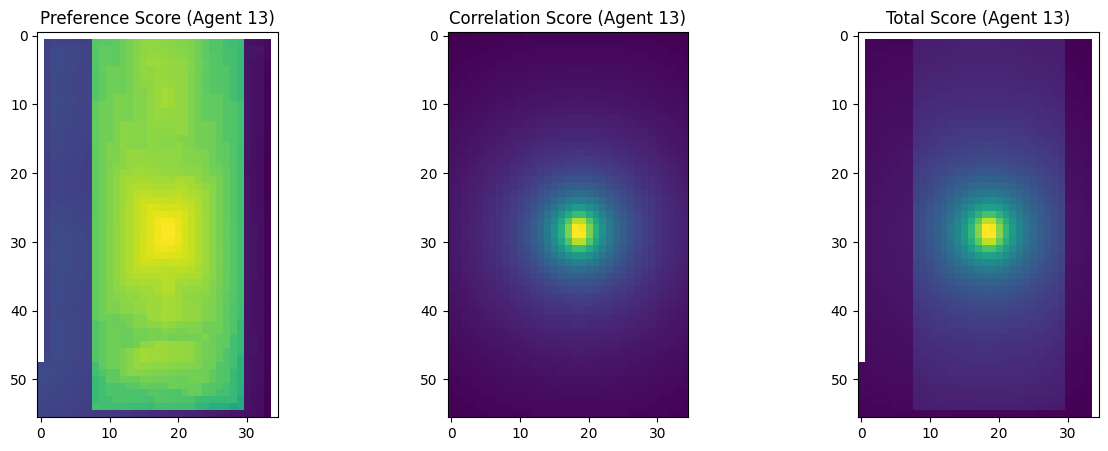

Agent 13:
Best location: (29, 19, 20)
Preference score at best location: 0.7035
Correlation score at best location: 5.3072
Total score at best location: 6.0106




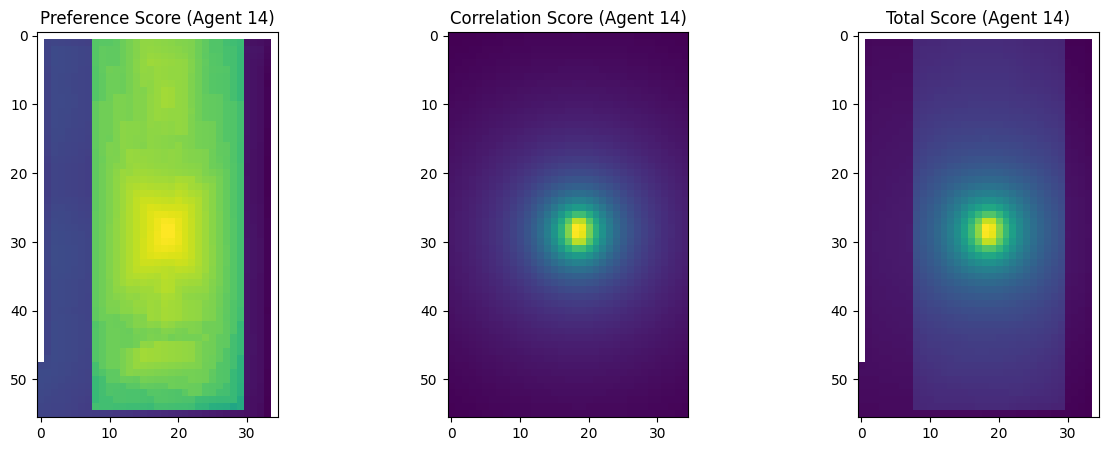

Agent 14:
Best location: (28, 18, 20)
Preference score at best location: 0.7047
Correlation score at best location: 3.4263
Total score at best location: 4.1310




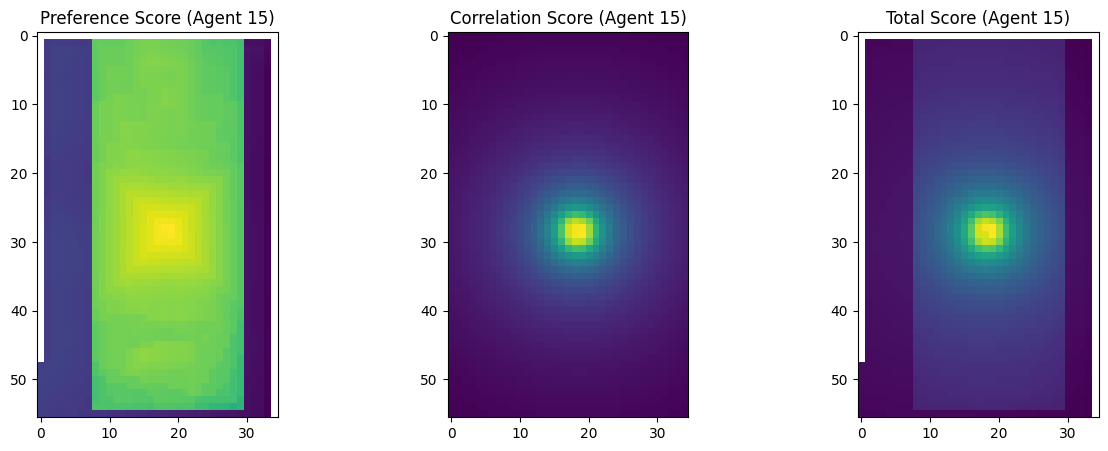

Agent 15:
Best location: (29, 19, 22)
Preference score at best location: 0.7232
Correlation score at best location: 4.2580
Total score at best location: 4.9812




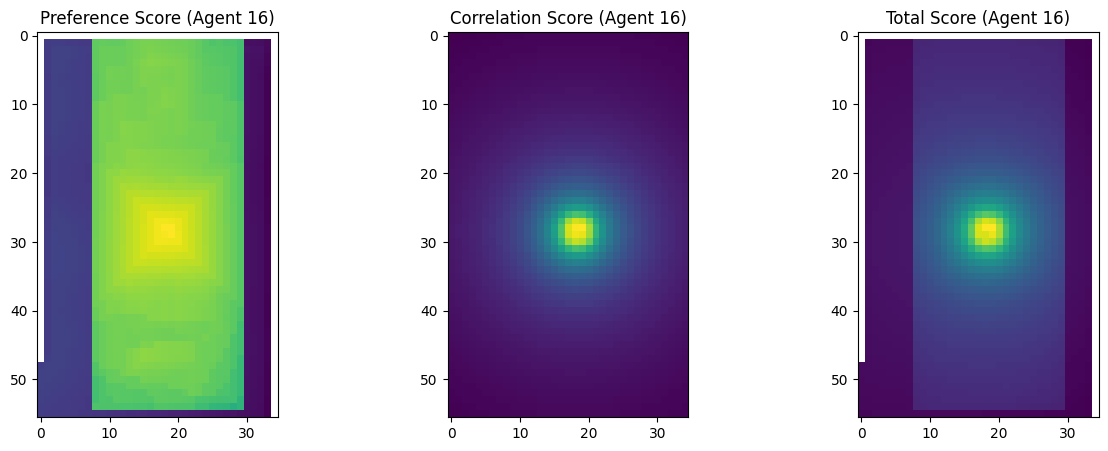

Agent 16:
Best location: (28, 19, 22)
Preference score at best location: 0.7230
Correlation score at best location: 4.0172
Total score at best location: 4.7402




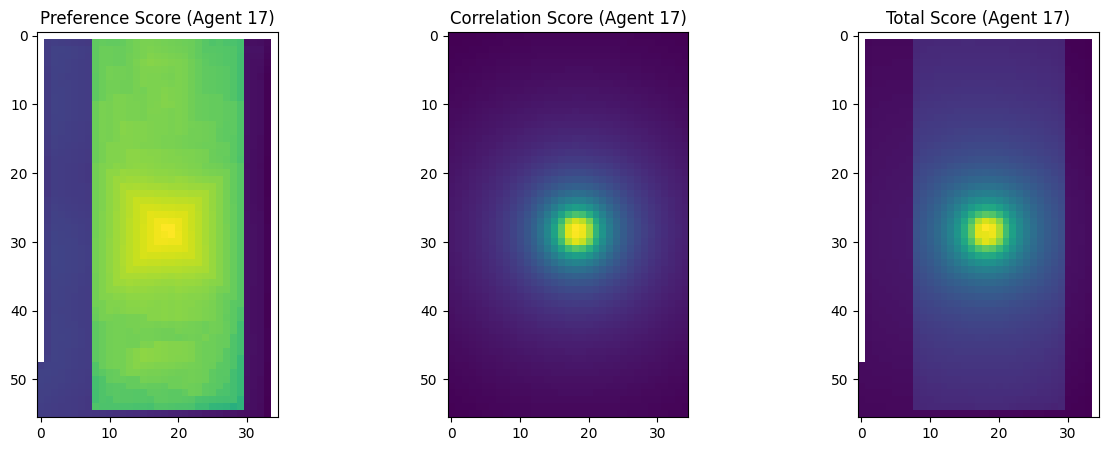

Agent 17:
Best location: (28, 18, 23)
Preference score at best location: 0.7280
Correlation score at best location: 3.8450
Total score at best location: 4.5730




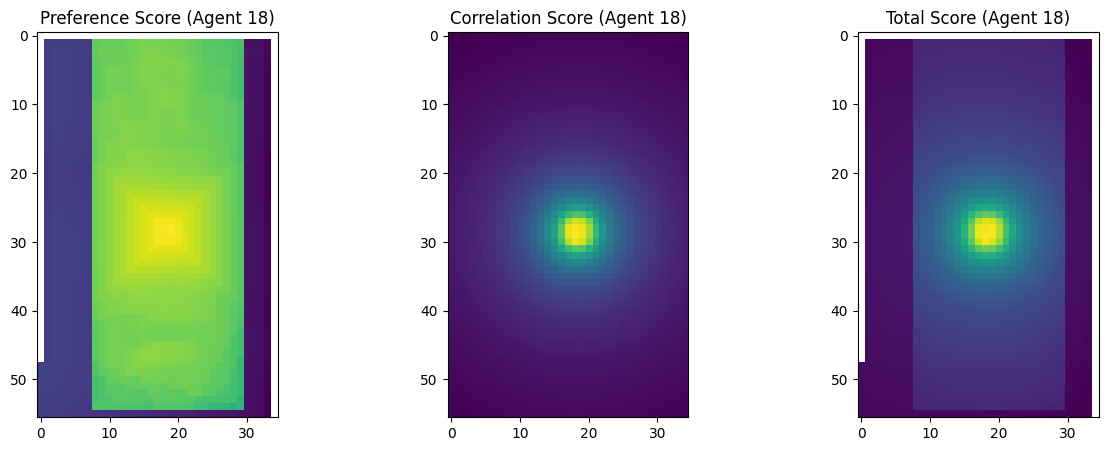

Agent 18:
Best location: (29, 18, 21)
Preference score at best location: 0.7206
Correlation score at best location: 3.9756
Total score at best location: 4.6962




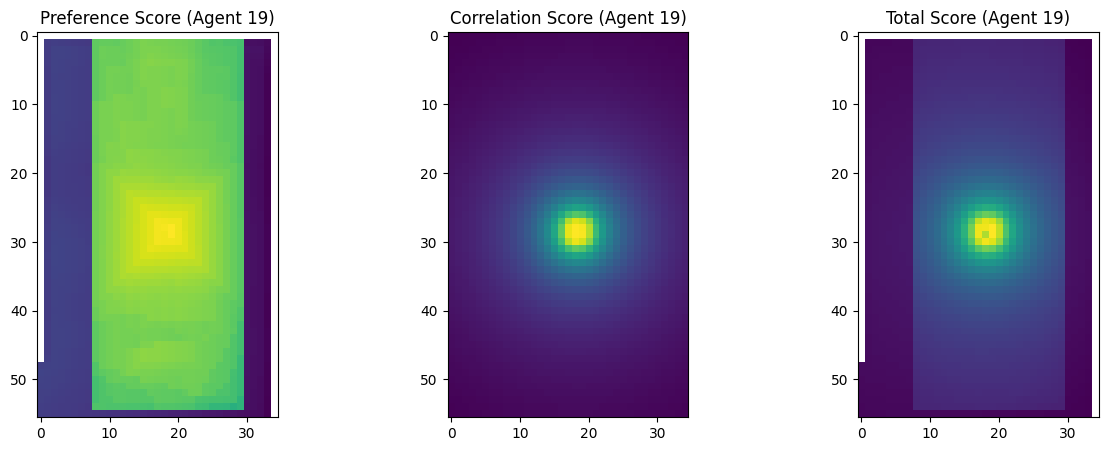

Agent 19:
Best location: (29, 19, 23)
Preference score at best location: 0.7270
Correlation score at best location: 4.2443
Total score at best location: 4.9713




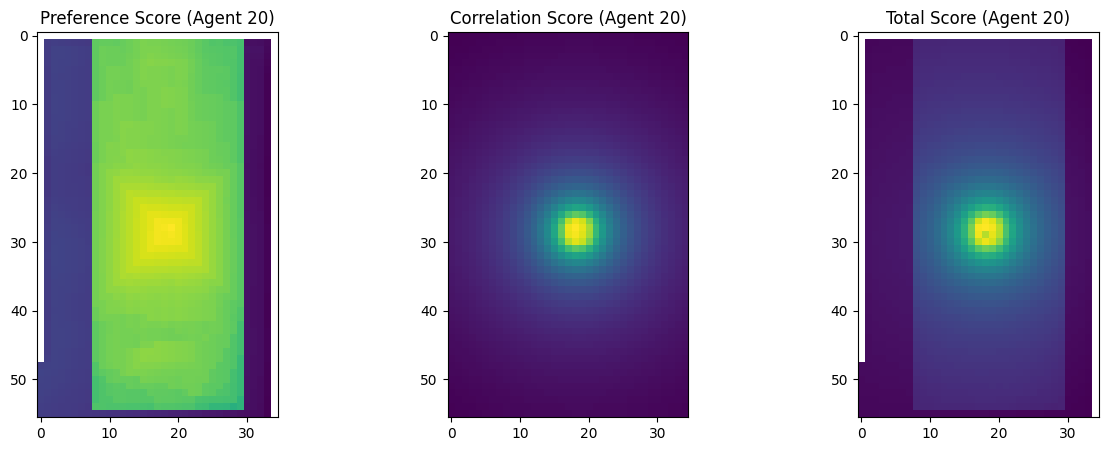

Agent 20:
Best location: (28, 18, 21)
Preference score at best location: 0.7204
Correlation score at best location: 4.1810
Total score at best location: 4.9014




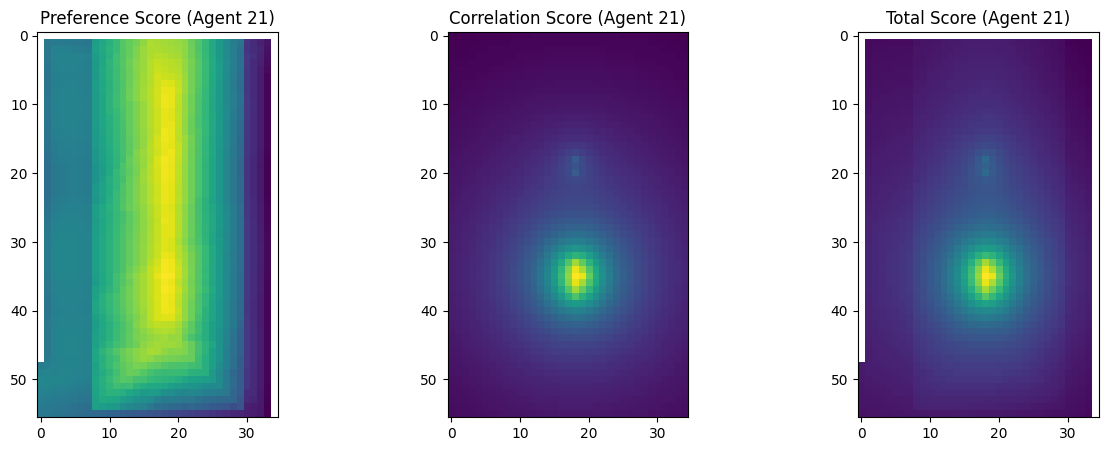

Agent 21:
Best location: (35, 18, 8)
Preference score at best location: 0.6450
Correlation score at best location: 4.1599
Total score at best location: 4.8048




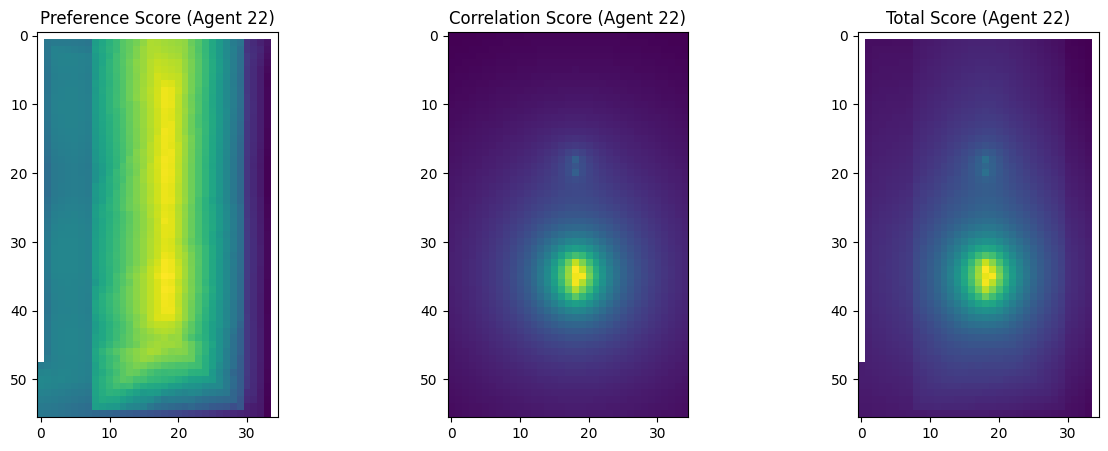

Agent 22:
Best location: (34, 18, 7)
Preference score at best location: 0.6401
Correlation score at best location: 3.1770
Total score at best location: 3.8171




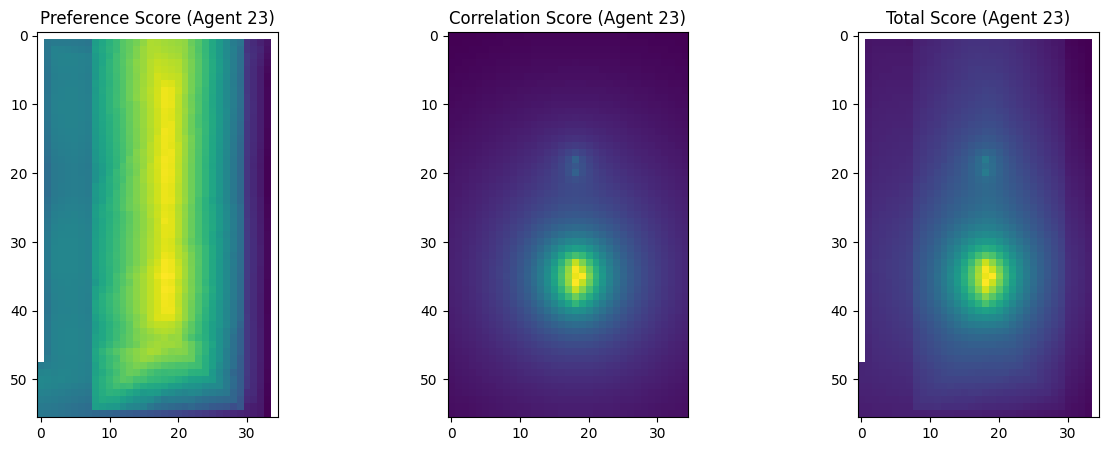

Agent 23:
Best location: (36, 18, 7)
Preference score at best location: 0.6388
Correlation score at best location: 1.9743
Total score at best location: 2.6131




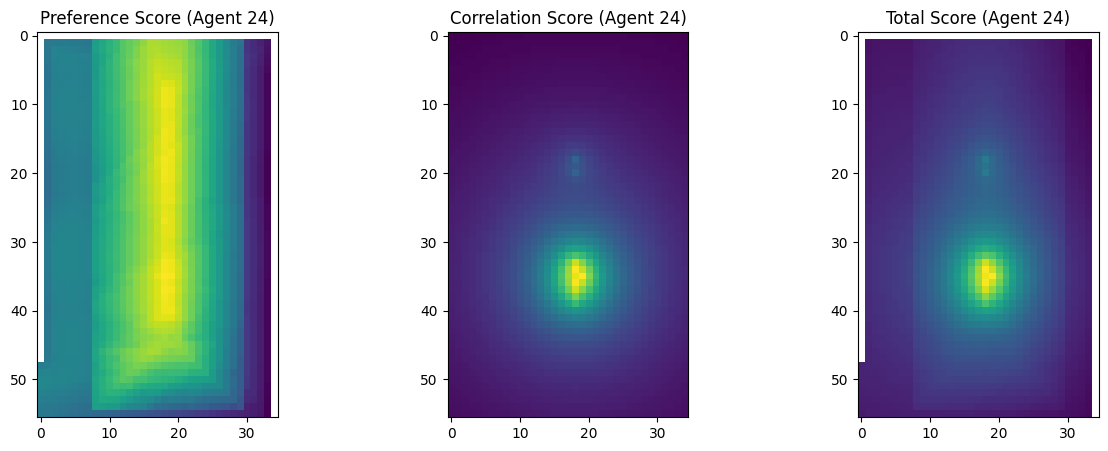

Agent 24:
Best location: (35, 19, 8)
Preference score at best location: 0.6406
Correlation score at best location: 2.2667
Total score at best location: 2.9074




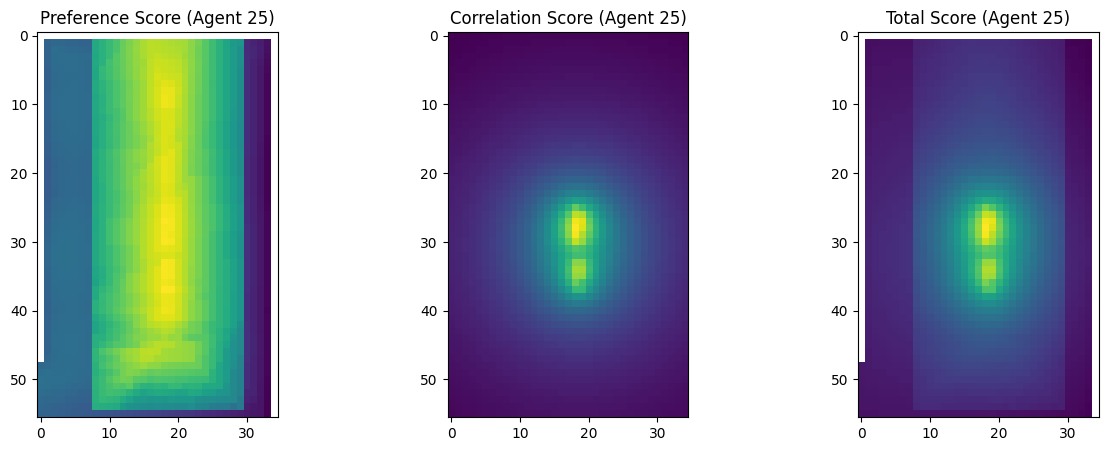

Agent 25:
Best location: (28, 18, 17)
Preference score at best location: 0.6527
Correlation score at best location: 2.6966
Total score at best location: 3.3493




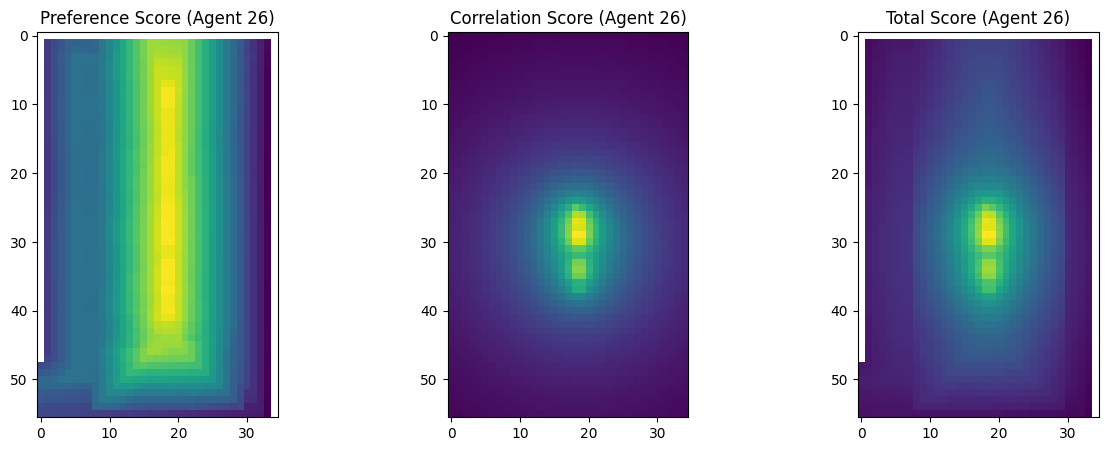

Agent 26:
Best location: (29, 18, 17)
Preference score at best location: 0.7266
Correlation score at best location: 2.0856
Total score at best location: 2.8121




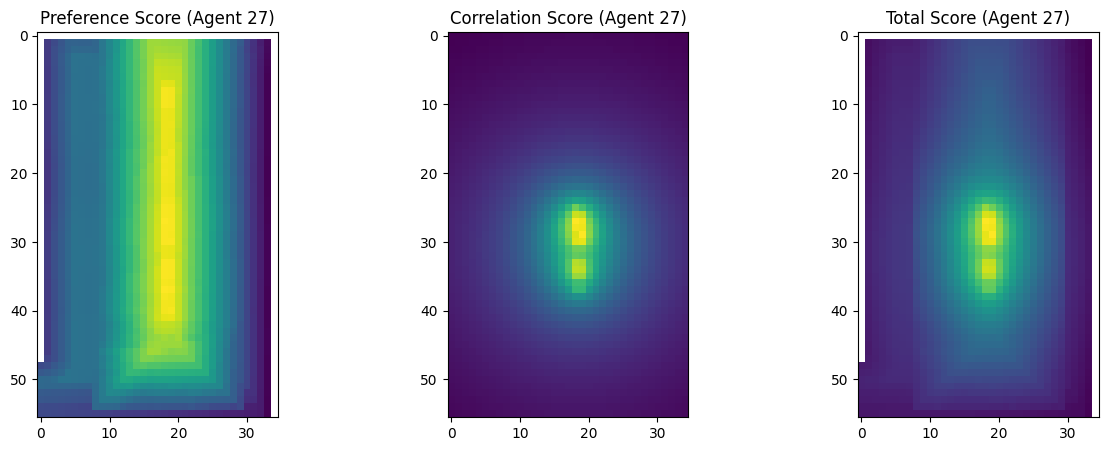

Agent 27:
Best location: (27, 18, 15)
Preference score at best location: 0.7275
Correlation score at best location: 1.5910
Total score at best location: 2.3184




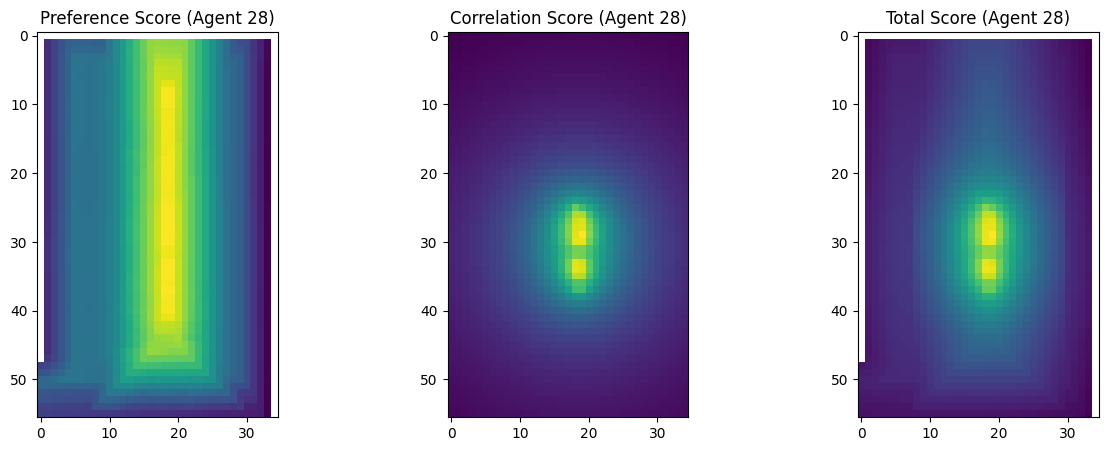

Agent 28:
Best location: (29, 19, 17)
Preference score at best location: 0.7577
Correlation score at best location: 2.0602
Total score at best location: 2.8179




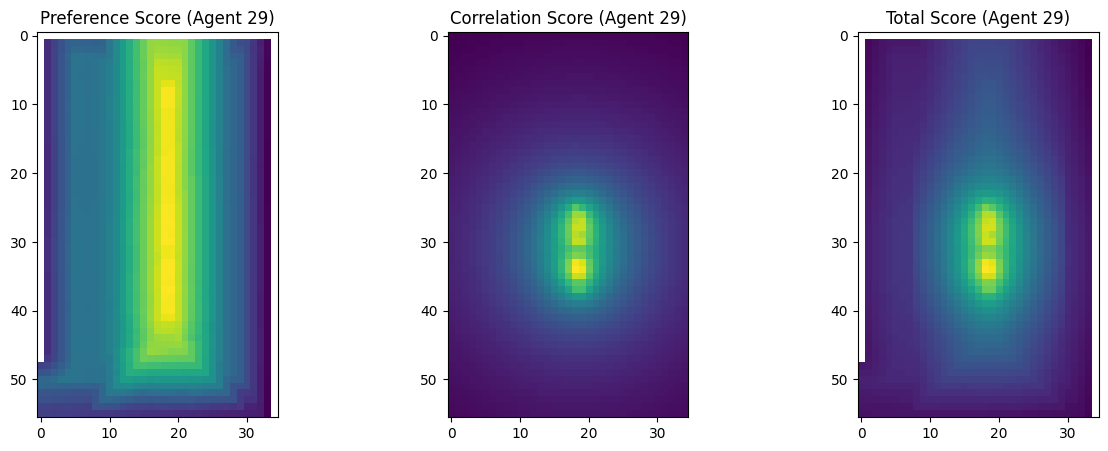

Agent 29:
Best location: (34, 18, 13)
Preference score at best location: 0.7609
Correlation score at best location: 2.1254
Total score at best location: 2.8864




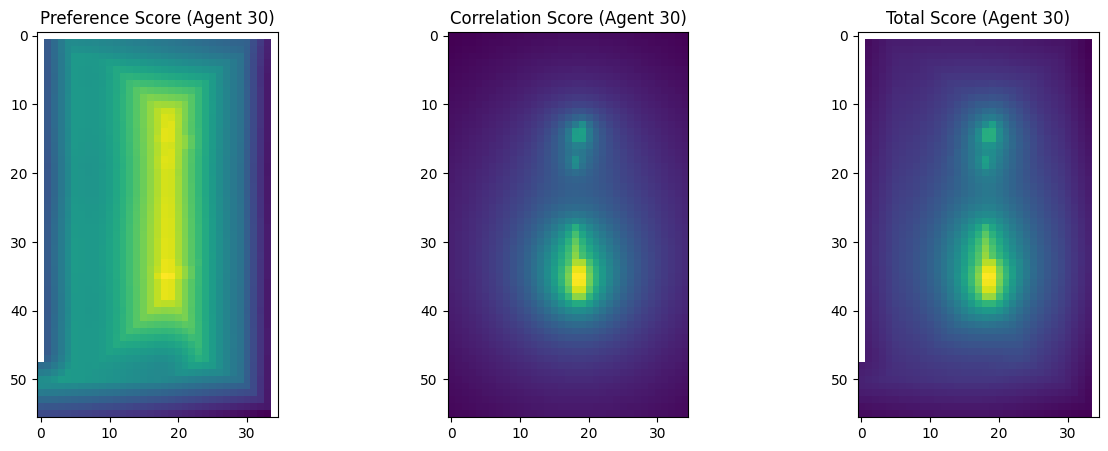

Agent 30:
Best location: (35, 18, 5)
Preference score at best location: 0.7542
Correlation score at best location: 1.2644
Total score at best location: 2.0186




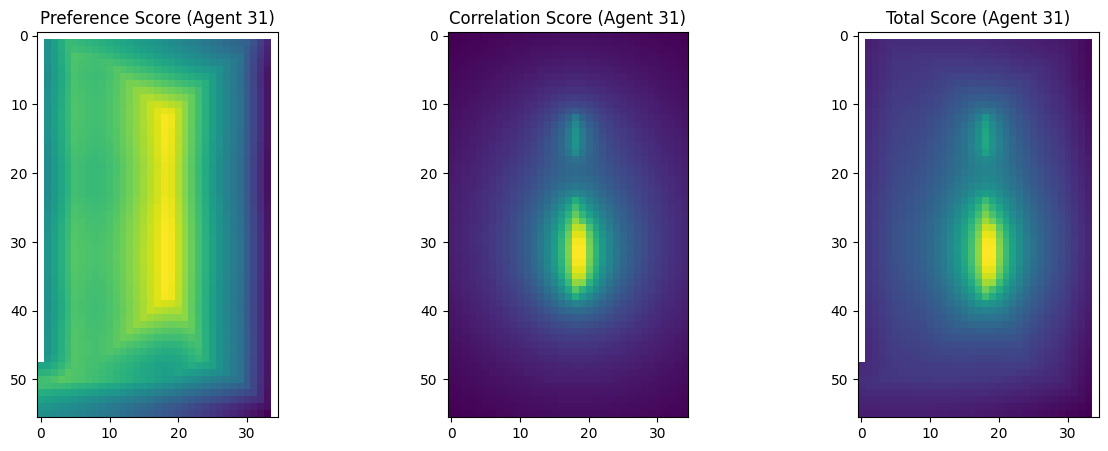

Agent 31:
Best location: (31, 18, 0)
Preference score at best location: 0.7387
Correlation score at best location: 1.2451
Total score at best location: 1.9838




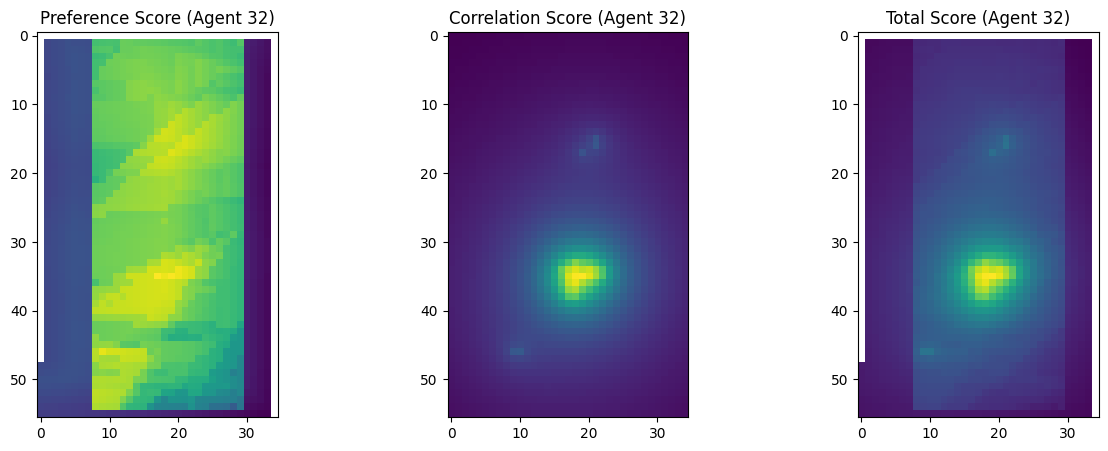

Agent 32:
Best location: (35, 19, 5)
Preference score at best location: 0.7133
Correlation score at best location: 2.0010
Total score at best location: 2.7142




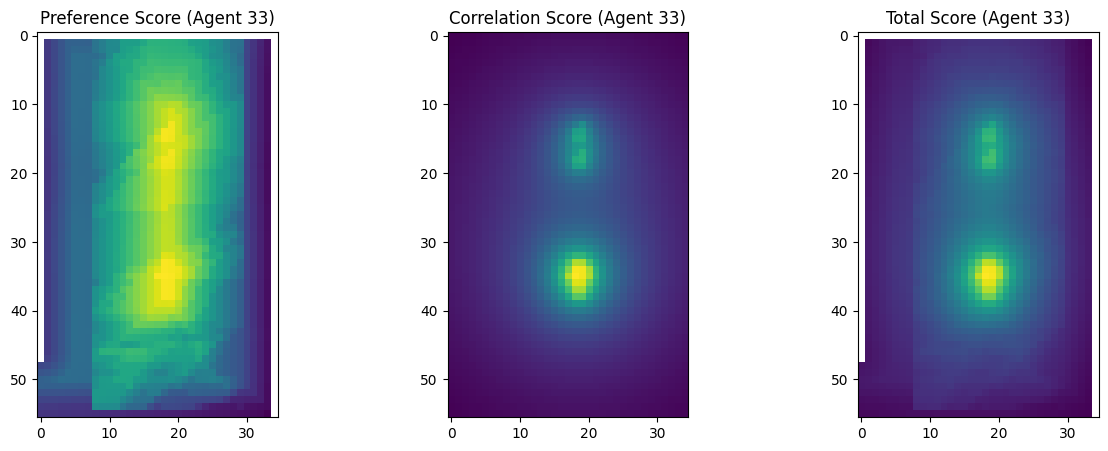

Agent 33:
Best location: (35, 18, 6)
Preference score at best location: 0.7471
Correlation score at best location: 1.5863
Total score at best location: 2.3334




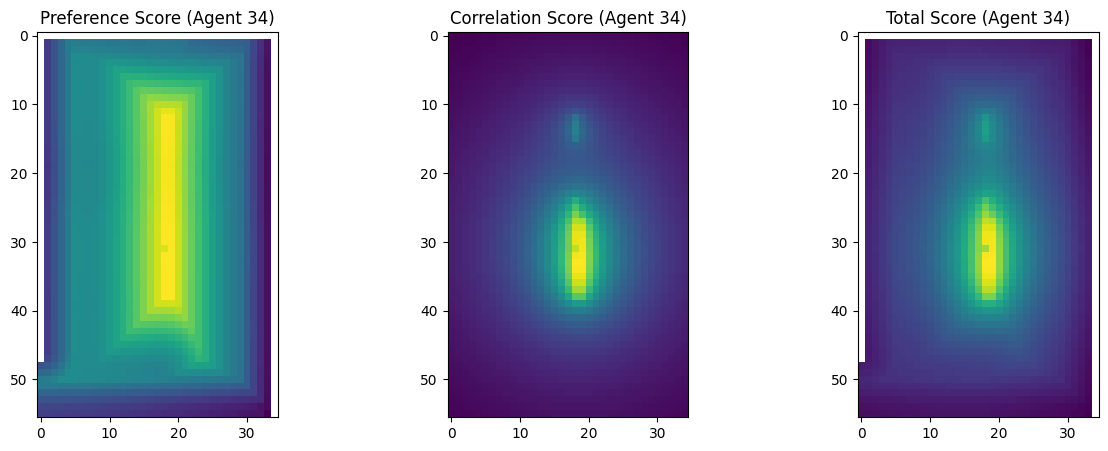

Agent 34:
Best location: (33, 19, 0)
Preference score at best location: 0.8194
Correlation score at best location: 1.3545
Total score at best location: 2.1739




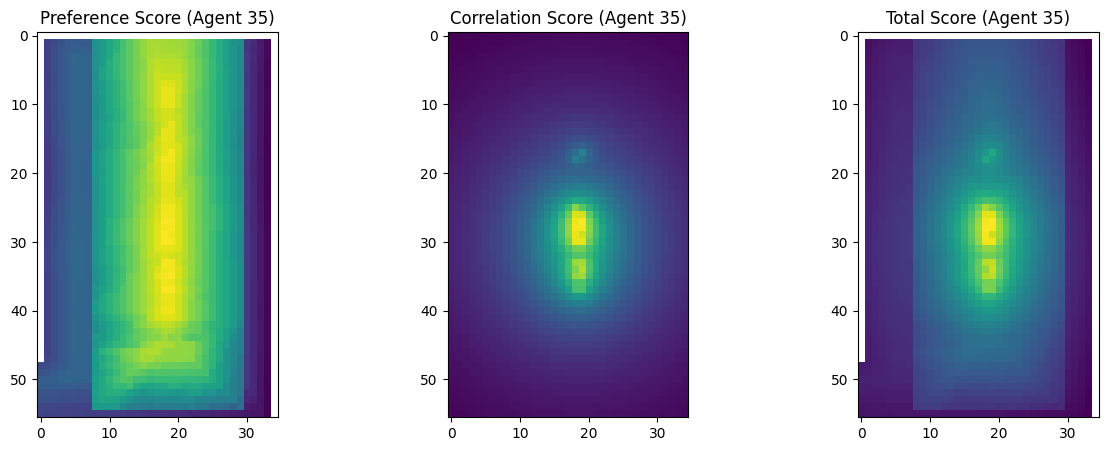

Agent 35:
Best location: (27, 19, 15)
Preference score at best location: 0.7325
Correlation score at best location: 1.5127
Total score at best location: 2.2452




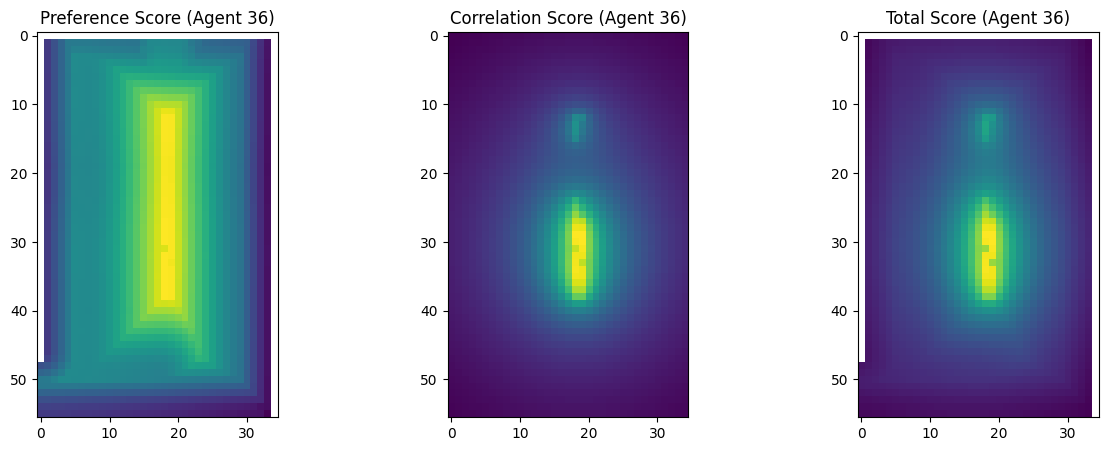

Agent 36:
Best location: (30, 19, 0)
Preference score at best location: 0.7650
Correlation score at best location: 1.7380
Total score at best location: 2.5030




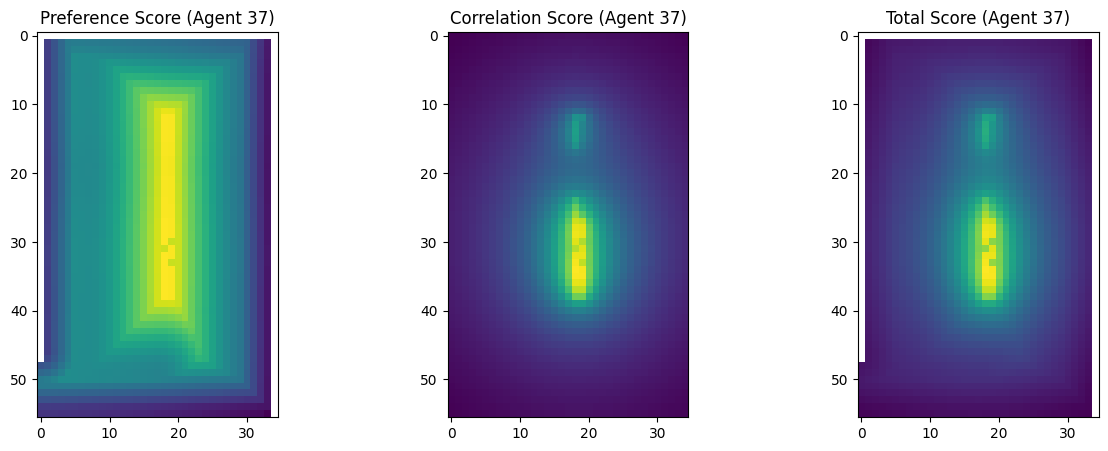

Agent 37:
Best location: (34, 18, 0)
Preference score at best location: 0.7925
Correlation score at best location: 1.9222
Total score at best location: 2.7147




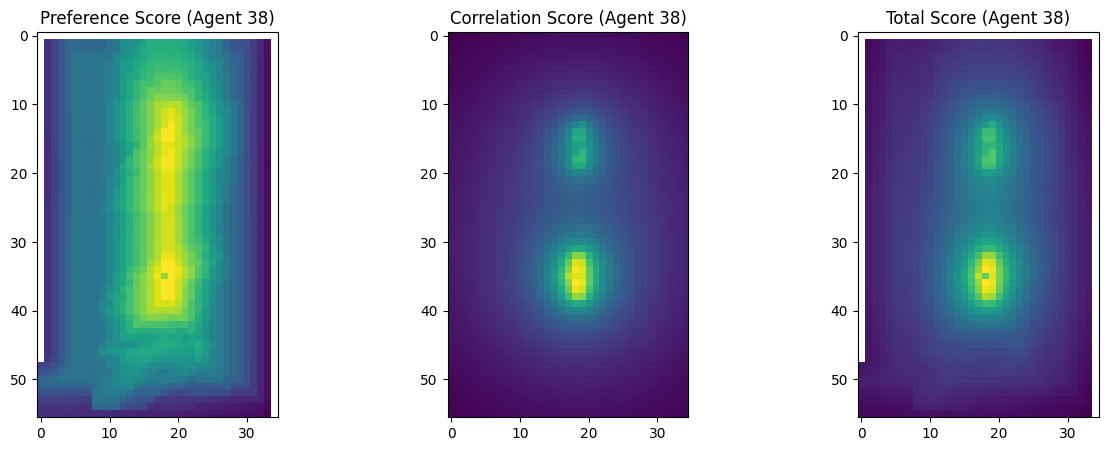

Agent 38:
Best location: (36, 18, 5)
Preference score at best location: 0.7512
Correlation score at best location: 1.4335
Total score at best location: 2.1848




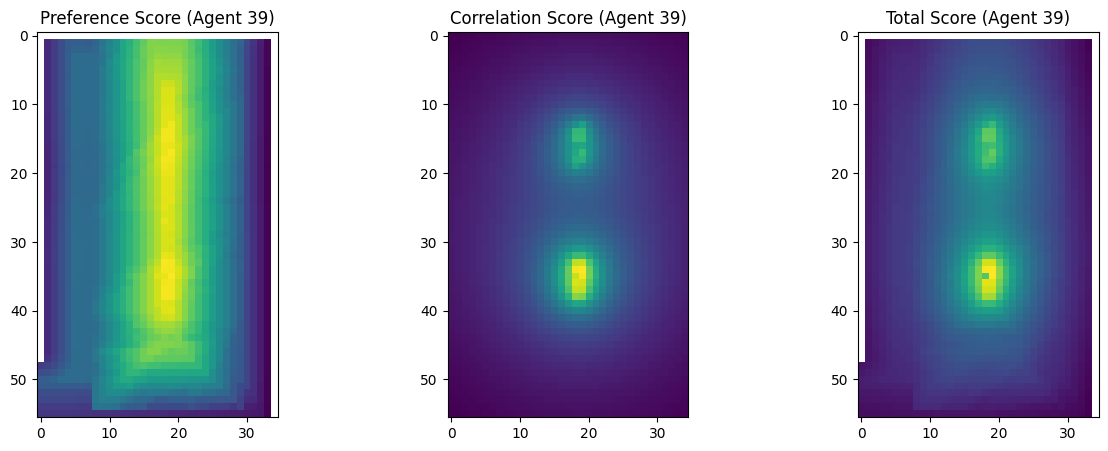

Agent 39:
Best location: (34, 19, 6)
Preference score at best location: 0.7422
Correlation score at best location: 1.6307
Total score at best location: 2.3730




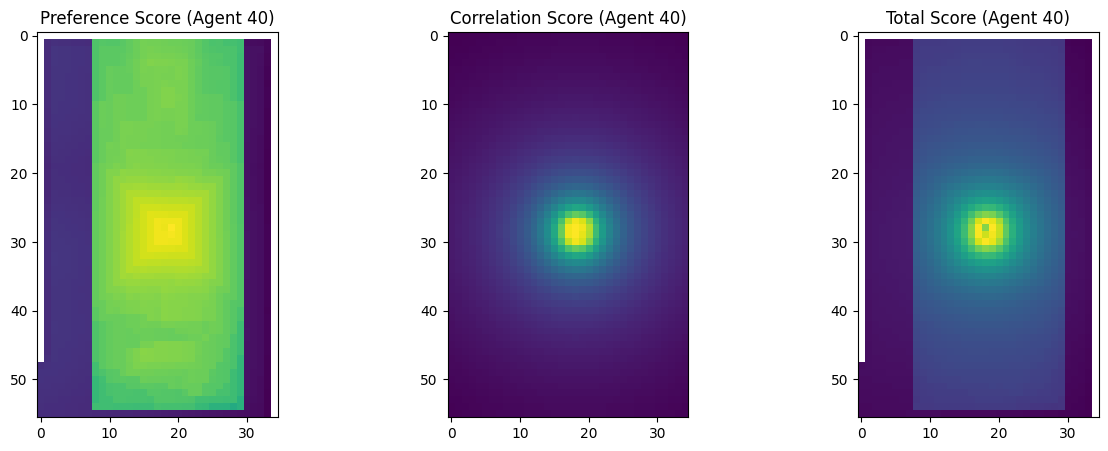

Agent 40:
Best location: (28, 19, 23)
Preference score at best location: 0.7545
Correlation score at best location: 2.2490
Total score at best location: 3.0035




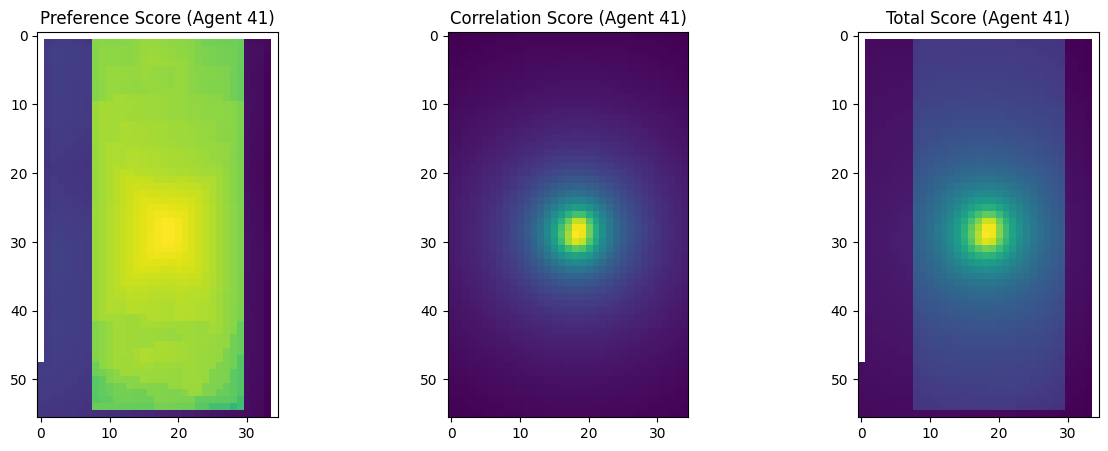

Agent 41:
Best location: (29, 18, 20)
Preference score at best location: 0.7142
Correlation score at best location: 2.3642
Total score at best location: 3.0785




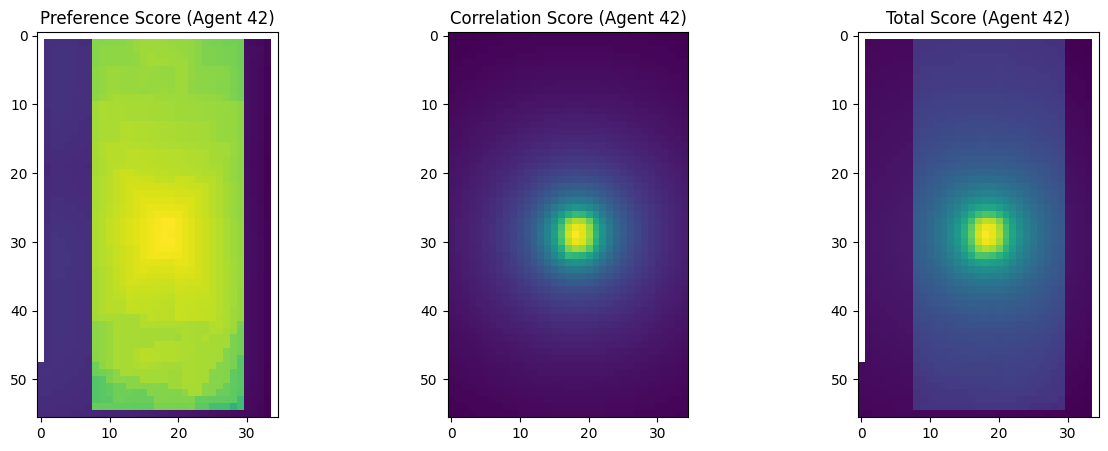

Agent 42:
Best location: (29, 18, 18)
Preference score at best location: 0.7588
Correlation score at best location: 2.9552
Total score at best location: 3.7139




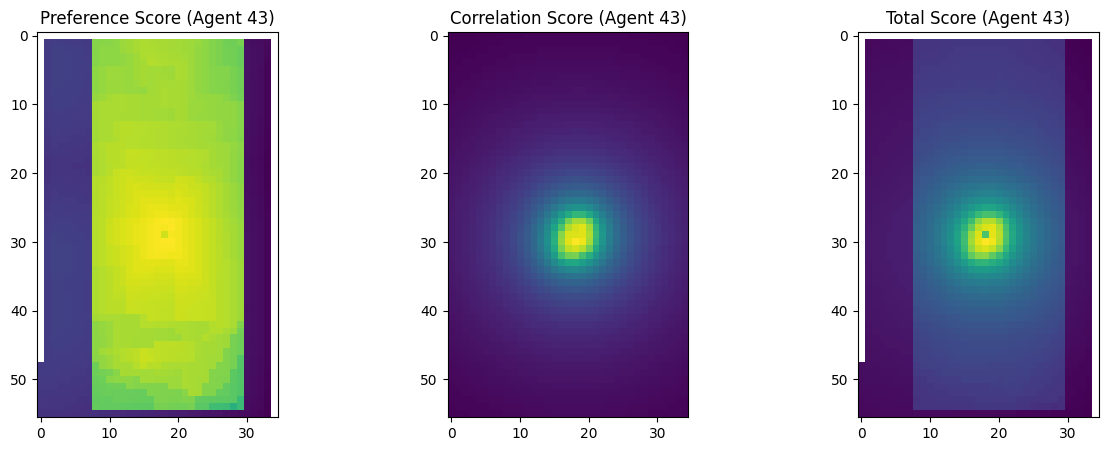

Agent 43:
Best location: (30, 18, 18)
Preference score at best location: 0.7452
Correlation score at best location: 2.8189
Total score at best location: 3.5641




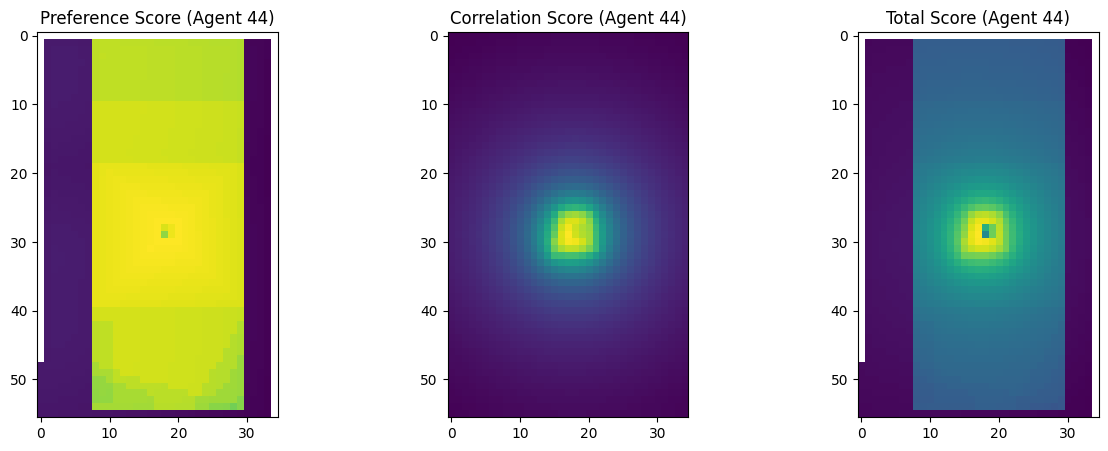

Agent 44:
Best location: (29, 17, 23)
Preference score at best location: 0.8481
Correlation score at best location: 1.6841
Total score at best location: 2.5322




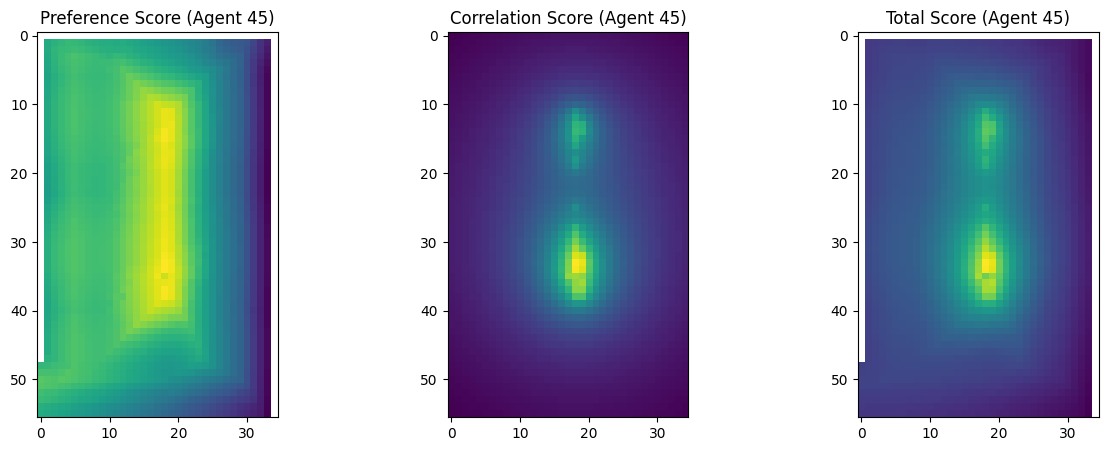

Agent 45:
Best location: (33, 18, 5)
Preference score at best location: 0.7215
Correlation score at best location: 1.0440
Total score at best location: 1.7655




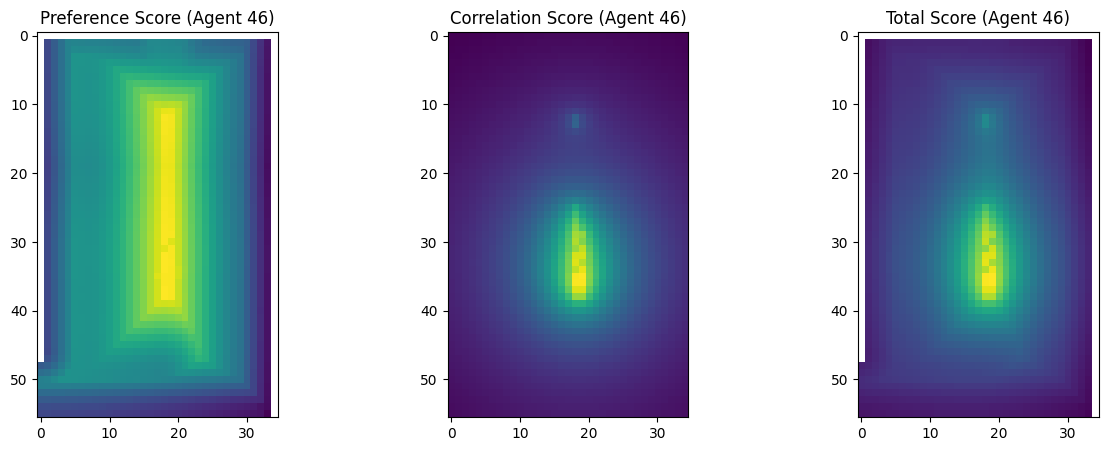

Agent 46:
Best location: (35, 19, 0)
Preference score at best location: 0.7600
Correlation score at best location: 1.0719
Total score at best location: 1.8319




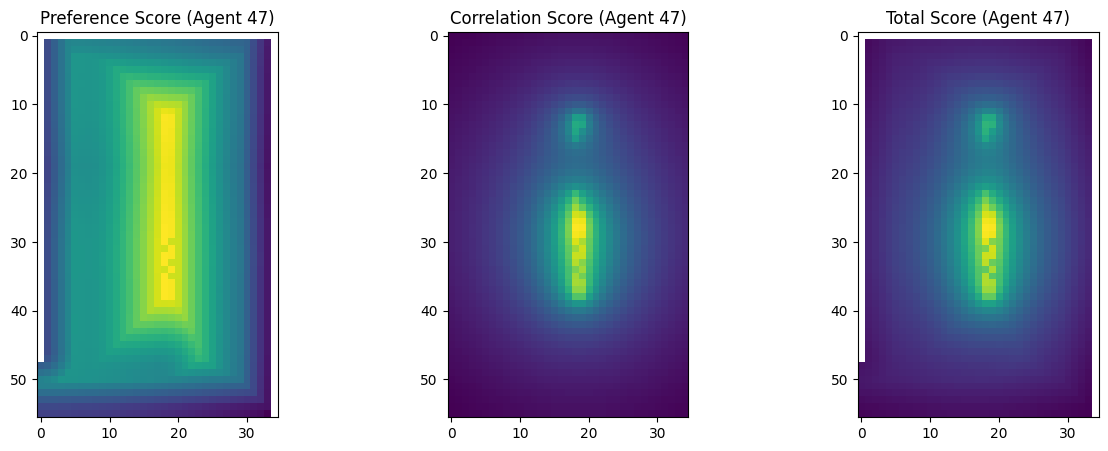

Agent 47:
Best location: (28, 18, 0)
Preference score at best location: 0.7864
Correlation score at best location: 2.2696
Total score at best location: 3.0560




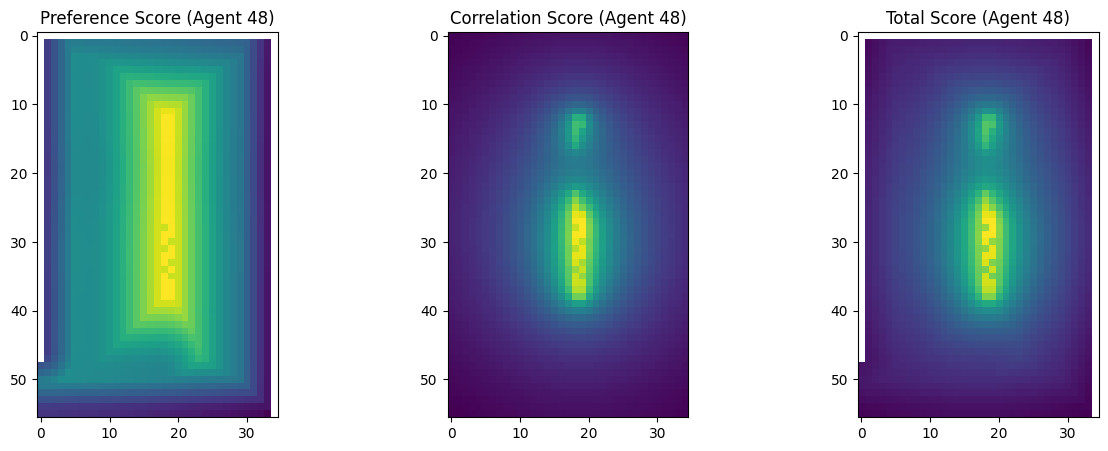

Agent 48:
Best location: (28, 19, 0)
Preference score at best location: 0.7907
Correlation score at best location: 2.0628
Total score at best location: 2.8536




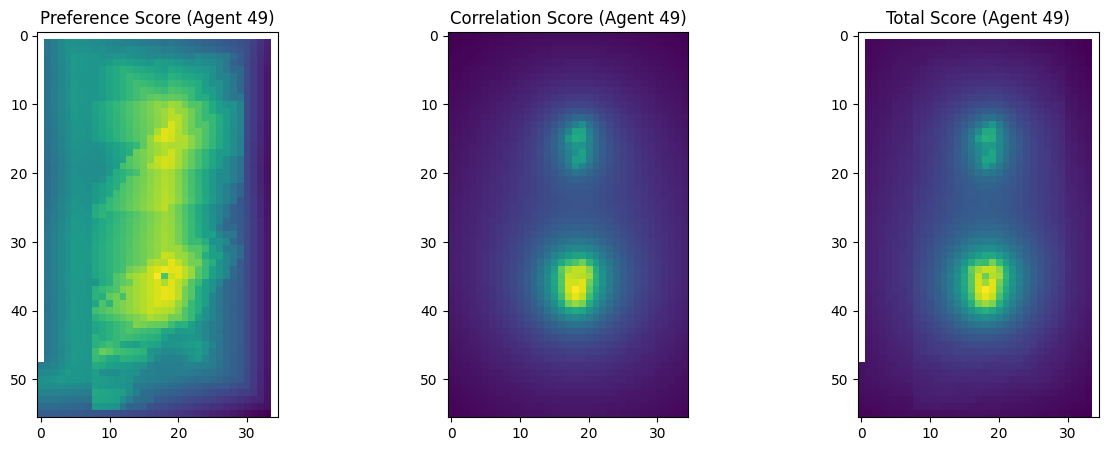

Agent 49:
Best location: (37, 18, 5)
Preference score at best location: 0.7058
Correlation score at best location: 2.6205
Total score at best location: 3.3263




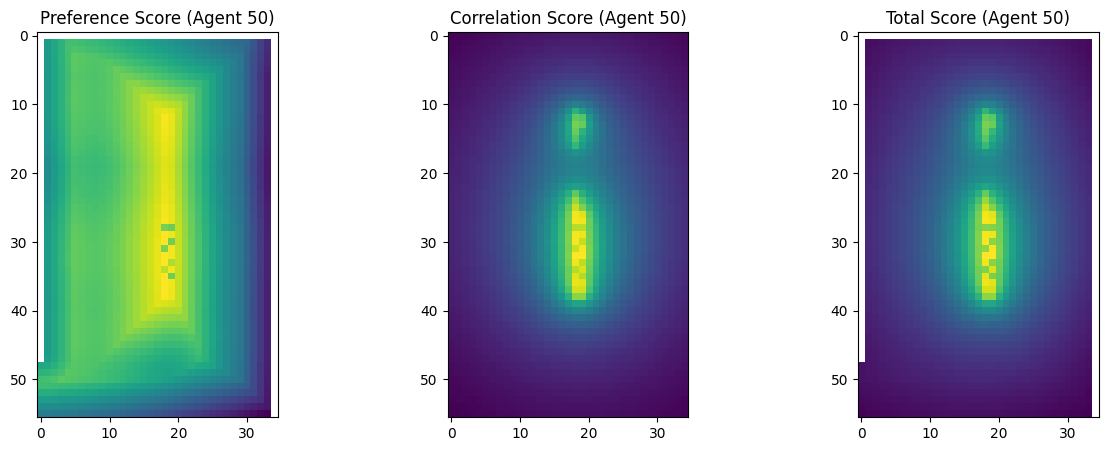

Agent 50:
Best location: (32, 18, 0)
Preference score at best location: 0.7334
Correlation score at best location: 2.1331
Total score at best location: 2.8665


Final agent locations:
Agent 0: Location = (39, 8, 5)
Agent 1: Location = (39, 10, 5)
Agent 2: Location = (38, 9, 5)
Agent 3: Location = (38, 12, 5)
Agent 4: Location = (35, 18, 7)
Agent 5: Location = (28, 18, 18)
Agent 6: Location = (35, 18, 9)
Agent 7: Location = (29, 18, 22)
Agent 8: Location = (29, 19, 18)
Agent 9: Location = (28, 19, 20)
Agent 10: Location = (29, 18, 19)
Agent 11: Location = (28, 18, 22)
Agent 12: Location = (29, 18, 23)
Agent 13: Location = (29, 19, 20)
Agent 14: Location = (28, 18, 20)
Agent 15: Location = (29, 19, 22)
Agent 16: Location = (28, 19, 22)
Agent 17: Location = (28, 18, 23)
Agent 18: Location = (29, 18, 21)
Agent 19: Location = (29, 19, 23)
Agent 20: Location = (28, 18, 21)
Agent 21: Location = (35, 18, 8)
Agent 22: Location = (34, 18, 7)
Agent 23: Location = (36, 18, 7)
Agent 24: Location = 

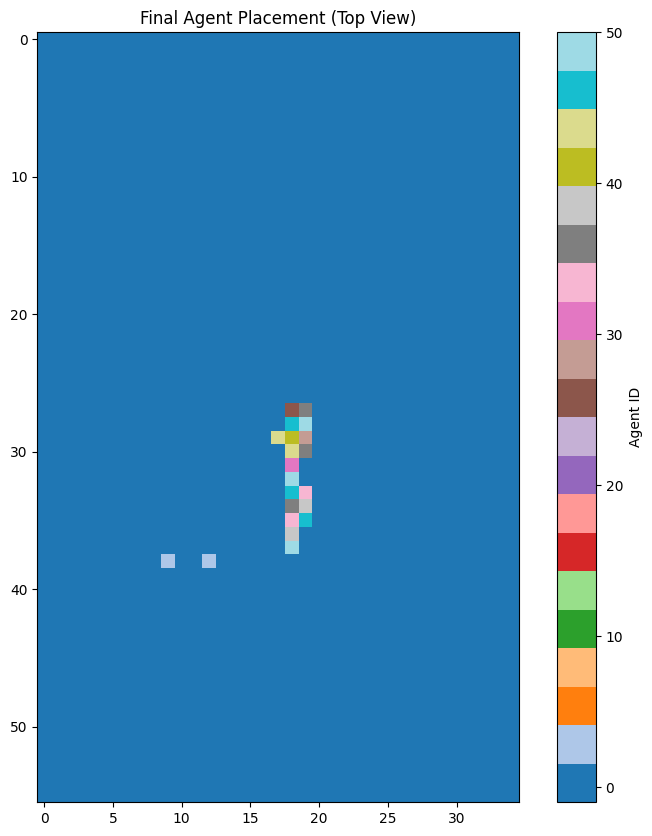

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

agn_num = len(program_prefs)
occ_lattice = avail_lattice * 0 - 1
init_avail_lattice = np.copy(avail_lattice)
# 
def calculate_pref_score(a_id):
    pref_lattice = np.zeros_like(avail_lattice, dtype=float)
    for f, w in program_prefs.iloc[a_id].items():
        pref_lattice += fields[f] * w
    return pref_lattice / sum(program_prefs.iloc[a_id])

def calculate_corr_score(a_id, placed_agents, locations):
    corr_lattice = np.zeros_like(avail_lattice, dtype=float)
    if placed_agents:
        x, y, z = np.meshgrid(np.arange(avail_lattice.shape[0]),
                              np.arange(avail_lattice.shape[1]),
                              np.arange(avail_lattice.shape[2]),
                              indexing='ij')
        for loc in locations:
            for other_agent, other_loc in placed_agents:
                correlation = program_mtx.iloc[a_id, other_agent]
                distances = np.sqrt((x - loc[0])**2 + (y - loc[1])**2 + (z - loc[2])**2)
                corr_lattice += correlation / (distances + 1)
        corr_lattice /= len(placed_agents)
    return corr_lattice

def find_best_location(a_id, placed_agents):
    pref_lattice = calculate_pref_score(a_id)
    pref_lattice[init_avail_lattice == 0] = -np.inf
    
    # 상위 30개 위치 선택
    top_30_indices = np.argpartition(pref_lattice.flatten(), -30)[-30:]
    top_30_locations = np.array(np.unravel_index(top_30_indices, pref_lattice.shape)).T
    
    # 선택된 위치에 대해 상관관계 점수 계산
    corr_lattice = calculate_corr_score(a_id, placed_agents, top_30_locations)
    
    # 최종 점수 계산
    total_score = pref_lattice + corr_lattice
    total_score[init_avail_lattice == 0] = -np.inf
    best_location = np.unravel_index(np.argmax(total_score), total_score.shape)
    
    # 결과 시각화
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(np.max(pref_lattice, axis=2), cmap='viridis')
    axs[0].set_title(f'Preference Score (Agent {a_id})')
    axs[1].imshow(np.max(corr_lattice, axis=2), cmap='viridis')
    axs[1].set_title(f'Correlation Score (Agent {a_id})')
    axs[2].imshow(np.max(total_score, axis=2), cmap='viridis')
    axs[2].set_title(f'Total Score (Agent {a_id})')
    plt.show()
    
    print(f"Agent {a_id}:")
    print(f"Best location: {best_location}")
    print(f"Preference score at best location: {pref_lattice[best_location]:.4f}")
    print(f"Correlation score at best location: {corr_lattice[best_location]:.4f}")
    print(f"Total score at best location: {total_score[best_location]:.4f}")
    print("\n")
    
    return best_location, total_score[best_location]

# 에이전트 배치
agn_locs = []
for a_id in range(agn_num):
    best_location, best_score = find_best_location(a_id, agn_locs)
    agn_locs.append((a_id, best_location))
    init_avail_lattice[best_location] = 0
    occ_lattice[best_location] = a_id

# 최종 결과 출력
print("Final agent locations:")
for i, (agent, loc) in enumerate(agn_locs):
    print(f"Agent {agent}: Location = {loc}")

# 최종 배치 시각화
plt.figure(figsize=(10, 10))
plt.imshow(np.max(occ_lattice, axis=2), cmap='tab20')
plt.colorbar(label='Agent ID')
plt.title('Final Agent Placement (Top View)')
plt.show()


In [59]:
from matplotlib.colors import ListedColormap

# PyVista 플로터 초기화
p = pv.Plotter(notebook=True)

# 그리드 설정
#base_lattice = frames[0]
grid = pv.ImageData()
grid.dimensions = np.array(occ_lattice.shape) + 1
# grid.origin과 grid.spacing 설정에 avail_lattice의 속성 사용
grid.origin = avail_lattice.minbound - avail_lattice.unit * 0.5
grid.spacing = avail_lattice.unit

# 데이터 할당
grid.cell_data["Agents"] = occ_lattice.flatten(order="F").astype(int)

# 필터링
agn_num = len(program_prefs)
threshed = grid.threshold([-0.1, agn_num - 0.9])

# 초기 컬러맵 설정
initial_colors = ["#808080" if i == 0 else "#FF0000" for i in range(len(program_prefs))]
custom_cmap = ListedColormap(initial_colors)

# 스칼라 바 설정
annotations = {i: name for i, name in enumerate(space_list.values())}
sargs = {
    "shadow": True,
    "n_labels": len(program_prefs),
    "italic": False,
    "fmt": " %.0f",
    "font_family": "arial",
    "height": 1,
    "vertical": True,
    "title_font_size": 10,
    "label_font_size": 6
}

# 메시 추가
opacity_map = np.full(threshed.n_cells, 0.1)  # 초기 투명도 설정
threshed.cell_data['opacity'] = opacity_map
mesh = p.add_mesh(threshed, scalars='opacity', cmap=custom_cmap, show_scalar_bar=True, scalar_bar_args=sargs, show_edges=True, opacity=1)

# 텍스트 추가
text_actor = p.add_text("Selected Program: None", position='upper_right', font_size=12, color='black')

# 슬라이더 콜백 함수
def slider_callback(value):
    selected_program = int(value)
    mask = threshed.cell_data['Agents'] == selected_program
    opacity = np.full(threshed.n_cells, 0.1)  # 기본 투명도 설정
    opacity[mask] = 1.0  # 선택된 프로그램에 높은 투명도 부여

    # 투명도 업데이트
    threshed.cell_data['opacity'] = opacity
    
    # 텍스트 업데이트
    text_actor.SetText(0, f"Selected Program: {annotations[selected_program]}")
    p.render()

# 슬라이더 위젯 추가
p.add_slider_widget(slider_callback, [0, len(program_prefs) - 1], value=0, title='Program Index')
p.add_mesh(threshed, name='sphere', show_edges=True, opacity=1.0, show_scalar_bar=True, annotations=annotations, scalar_bar_args=sargs, cmap=custom_cmap)

p.add_mesh(tri_to_pv(context_mesh), color='#aaaaaa', opacity=0.3)
p.add_mesh(entrance_pc, color='red', opacity=1.0)
# 시각화 표시
p.show(jupyter_backend="trame", return_viewer=True)


Widget(value='<iframe src="http://localhost:56906/index.html?ui=P_0x20c0ff695d0_12&reconnect=auto" class="pyvi…